TP1 - Recalage d'images - SKANDER RAHAL 4MA- INSA TOULOUSE
=============

In [1]:
import numpy as np
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt

Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

In [2]:
def get_images() :
    n=21
    sigma=0.3
    [X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n), indexing='xy')
    Z=np.sqrt(X*X+Y*Y)
    im1=np.zeros((n,n))
    im1[Z<=.7]=1.
    im1[Z<=.3]=.5
    im1[Z<=.1]=.7
    im2=np.zeros((n,n));
    Z=np.sqrt((X-.3)**2+(Y+.2)**2)
    im2[Z<=.7]=1
    im2[Z<=.3]=.5
    im2[Z<=.1]=.7
    G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
    f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
    g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
    f=f/np.max(f)
    g=g/np.max(g)
    return f,g

In [3]:
f,g=get_images()

# 1. Formalisation du problème

1.1 Formalisme continu
---------------------

On modélise les images en niveaux de gris comme des fonctions d’un ensemble borné $\Omega\subset \mathbb{R}$ (typiquement un carré) dans $\mathbb{R}$. La valeur de la fonction en chaque point représente l’intensité lumineuse de l’image. 

Soient $f$ et $g$ deux images. On a donc :
$$
f:\Omega\subset \mathbb{R}^2 \to \mathbb{R},  g:\Omega\subset \mathbb{R}^2 \to \mathbb{R} 
$$
En supposant que les images $f$ et $g$ dépendent seulement d’une transformation géométrique qui conserve la luminosité, le problème de recalage peut être formulé comme suit:

> Problème inverse $(P_1)$ : 

> Etant donnés $f$ et $g$ dans $H_1(\Omega)$ (les images ont une amplitude bornée et une énergie finie), trouver un champ de vecteurs $u = (u_1, u_2) \in H_1(\Omega)^2$ tel que:
$$f(x + u(x)) = g(x), \forall x\in \Omega.$$


Le problème inverse est mal posé: tout d'abord, l'existence d'une solution n'est pas garantie, et dans le cas où il existe une solution, on n'a pas nécessairement unicité de cette solution. Par exemple, si $f$ et $g$ sont des fonctions constantes, n'importe quel déplacement $u$ est solution

Pour le résoudre, on se propose de le reformuler comme un problème d'optimisation: 

> $(P_2)$ On cherche une déformation $u$ du plan qui minimise:
$$
E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
$$

Sans hypothèse supplémentaire, le problème $\displaystyle \min_{u \in H^1(\Omega)^2} E(u)$ n'est a priori pas convexe, toujours mal posé et même éventuellement non différentiable si $u$ et $f$ ne sont pas assez régulières. On pourrait facilement rendre $f$ différentiable (en ajoutant du bruit par exemple à l'image, ce qui revient à convoler $f$ avec une gaussienne) mais il faut également "forcer" $u$ à être différentiable. Pour cela on propose de régulariser le problème de façon à assurer la convexité du problème d'optimisation considéré ainsi que l'existence et l'unicité des solutions.

Pour régulariser le problème inverse, nous allons faire une analogie avec l’élasticité linéaire. La fonction $u = (u_x,u_y)$ représente un champ de déformations. En notant $\partial x$ et $\partial y$ les opérateurs de dérivation partielle par rapport à chacun des axes du plan, on peut définir un potentiel élastique linéarisé :
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2(x,y) dxdy}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2(x,y) dxdy}_{R_2(u)=\textrm{variations \ de \ volume}}.
$$ 
En mécanique des structures, $\mu$ et $\lambda$ sont appelées constantes de Lamé. Le paramètre $\lambda$ n’a pas d’interprétation directe, tandis que le paramètre $\mu$ est appelé module de cisaillement.

Le problème d'optimisation à résoudre dans ce TP est le suivant:
> $$(P)\qquad \min_{u} E(u)+R(u).$$

Q1. A l'aide d'un développement de Taylor, vérifier que le gradient de $E$ s'écrit:

$$\nabla E(u) = \left(f\circ (id+u) -g\right)\nabla f\circ (id+u)$$

au sens où la différentielle de $E$ est définie par:

$$\langle \nabla E(u),h\rangle = \displaystyle\int_\Omega \langle (f(x+u(x))-g(x))\nabla f(x+u(x)),h(x)\rangle dx.$$

Réponse:

D'après le développement de Taylor, on sait que:

$$ f(x+u(x)+h(x))=f(x+u(x))+\langle \nabla f(x+u(x)),h(x)\rangle +o(\| h \|)$$

Donc on a :
$$\begin{align}
E(u+h) &= \displaystyle\frac{1}{2}\int_\Omega (f(x+u(x)+h(x))-g(x))^2 dx \\
&= \displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))+\langle \nabla f(x+u(x)),h(x)\rangle +o(\| h \|)-g(x))^2 dx\\
&= \displaystyle\frac{1}{2}\int_\Omega [f(x+u(x))-g(x)]^2 +2 \langle \nabla f(x+u(x)), h(x) \rangle ( f(x+u(x)) - g(x) ) + o(\|h\|) ) dx \\
&= E(u) + \int_{\Omega} \langle \left( f(x + u(x)) - g(x) \right) \nabla f(x + u(x)), h(x) \rangle dx + o(\|h\|)
\end{align}$$
Par suite comme:
$$ E(u+h)=E(u)+\langle \nabla E(u),h\rangle +o(\| h \|)\\$$
Donc par identification, on a que:
$$\nabla E(u)=\left(f\circ (id+u) -g\right)\nabla f\circ (id+u)$$


    

# 2. Discrétisation

Pour pouvoir résoudre numériquement le problème $(P)$ (dont les variables de l'optimisation sont des fonctions !), on propose de le discrétiser au préalable. 

Soit $1\le i \le n$ and $1\le j\le m$. Notons $(x_i,y_j)$ le point de la grille $(i,j)$ et $f_{i,j}$ la valeur de $f$ au point $(x_i,y_j)$. Le produit scalaire sur $V=\mathbb{R}^n\times \mathbb{R}^m$ est défini par:
$$\langle f,g\rangle_V=\sum_{i=1}^n\sum_{j=1}^m f_{i,j}g_{i,j},$$
défini sur $\mathbb{R}^n\times \mathbb{R}^m$. 

2.1. Calcul du $E$ et de son gradient
-----------------------------------

Pour pouvoir calculer $E$ et son gradient, on va avoir besoin d'évaluer $f\circ (Id+u)$ et $\nabla f\circ(id+u)$. C'est ce que fait la fonciton interpol ci-dessous.

In [4]:
def interpol(f,ux,uy) :
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),f)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

2.2. Calcul de $R$ et de son gradient
-------------------------------------
On discrétise également les opérateurs de dérivation partielles par différences finies ; par exemple la dérivée partielle par rapport à $x$ est donnée par:
$$\begin{cases}(\partial_x f)_{i,j}=f_{i+1,j}-f_{i,j} \text{ si } i<n \\
(\partial_x f)_{n,j}=0 \end{cases} $$

On peut alors écrire :
$$
R(u)= \frac{\mu}{2}\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i) + \frac{\lambda+\mu}{2} \sum_i(\partial_x u_x + \partial_y u_y)^2(i).
$$ 
où:
* $u_x\in\mathbb{R}^n$ et $u_y\in\mathbb{R}^n$ sont les discrétisations des composantes du champ de vecteurs $u$ sur la grille choisie et $\partial_x:\mathbb{R}^n\rightarrow\mathbb{R}^n$
* $\partial_y:\mathbb{R}^n\rightarrow\mathbb{R}^n$ représentent des opérateurs de différences finies.

On peut ré-écrire $R(u)=\frac{1}{2}R_1(u)+ \frac{1}{2} R_2(u)$ avec : 
$$
R_1(u)=\langle A_1 u , A_1 u\rangle,\qquad R_2(u)=\langle A_2 u , A_2 u\rangle.
$$

Q2. Donner les formules de discrétisation des opérateurs $\partial_y$, $\partial_x^\top$ et $\partial_y^\top$. Implémenter ces opérateurs ci-après.

On sait que : 

$$ \langle \partial _x ^T u, v \rangle = \langle  u, \partial _x v \rangle $$
donc :
$$\begin{align}
\langle \partial _x ^T u, v \rangle &=\sum_{i=1}^{n}\sum_{j=1}^{m}(\partial _x ^T u)_{i,j}.v_{ij}\\
&=\sum_{i=1}^{n}\sum_{j=1}^{m} u_{i,j}.(\partial _x v)_{ij}\\
&=\sum_{i=1}^{n-1}\sum_{j=1}^{m}u_{ij}(v_{i+1,j}-v_{ij})\\
&=\sum_{i=1}^{n-1}\sum_{j=1}^{m}u_{ij}v_{i+1,j}-\sum_{i=1}^{n-1}\sum_{j=1}^{m}u_{ij}v_{ij}\\
&=\sum_{i=2}^{n}\sum_{j=1}^{m}u_{i-1,j}v_{ij}-\sum_{i=1}^{n-1}\sum_{j=1}^{m}u_{ij}v_{ij}\\
&=\sum_{i=2}^{n-1}\sum_{j=1}^{m}u_{i-1,j}v_{ij}-\sum_{i=2}^{n-1}\sum_{j=1}^{m}u_{ij}v_{ij} - \sum_{j=1}^{m} u_{1j}v_{1j} + \sum_{j=1}^{m} u_{n-1,j}v_{nj}\\
&=\sum_{i=2}^{n-1}\sum_{j=1}^{m}(u_{i-1,j}-u_{ij})v_{i,j} + \sum_{j=1}^{m} u_{n-1,j}v_{n,j}-\sum_{j=1}^{m}u_{1j}v_{1j}\\ \\ \\
\end{align}$$

Par identification, on a que:
$$\partial _x ^T u=\begin{cases}u_{i-1,j}-u_{ij} \text{ si } i\geq 2  \text{ et } i \leq n-1 \\
        u_{n-1,j} \text{ si } i=n \\
        -u_{1,j} \text{ si } i=1 \end{cases} $$

De plus,
$$\partial _y ^T u=\begin{cases}u_{i,j-1}-u_{ij} \text{ si } j\geq 2  \text{ et } j \leq m-1 \\
        u_{i,m-1} \text{ si } j=m \\
        -u_{i,1} \text{ si } j=1 \end{cases} $$


In [5]:
def dx(im) :
    d=np.zeros(im.shape)
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d
def dy(im) :
    d=np.zeros(im.shape)
    d[:,:-1]=im[:,1:]-im[:,:-1]
    return d
def dyT(im) :
    d=np.zeros(im.shape)
    d[:,1:-1]=im[:,0:-2]-im[:,1:-1]
    d[:,-1]=im[:,-2]
    d[:,0]=-im[:,0]
    return d  
def dxT(im) :
    d=np.zeros(im.shape)
    d[1:-1,:]=im[0:-2,:]-im[1:-1,:]
    d[-1,:]=im[-2,:]
    d[0,:]=-im[0,:]
    return d

Q3. On écrit $R(u)$ comme un opérateur de $V^2$ dans $\mathbb{R}$. Montrer que $R(u)$ peut s'écrire sous la forme:
$$R(u)=\frac{1}{2} \langle A\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right),\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\rangle_{V^2},$$
et donnez l'expression des matrices $A_1$ et $A_2$ en fonction des opérateurs $\partial_x$, $\partial_x^\top$, $\partial_y$ et $\partial_y^\top$.

On sait que:
$$
R(u)= \frac{\mu}{2}\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i) + \frac{\lambda+\mu}{2} \sum_i(\partial_x u_x + \partial_y u_y)^2(i).
$$ 
De plus,
$$R(u) = \frac{1}{2} R_1(u) + \frac{1}{2} R_2(u) = \frac{1}{2} \langle A_1u,A_1u \rangle + \frac{1}{2} \langle A_2u,A_2u \rangle$$

Donc à partir de $R(u)$,on pourra retrouver l'expression de $A_{1}$ et $A_{2}$ en fonction des opérateurs $\partial_x$, $\partial_x^\top$, $\partial_y$ et $\partial_y^\top$.

Pour $A_{1}$:
$$R_{1}(u)= \|A_1u\|^2 = \left\|A_1 \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\right\|^2 = \mu \|\partial_x u_y + \partial_y u_x \|^2=\mu \|\left( \partial_y \text{ } \partial_x \right)\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\|^2$$
Donc, $$A_1 = \sqrt{\mu} \left( \partial_y \text{ } \partial_x \right)$$

Pour $A_{2}$:
$$R_{2}(u)= \|A_2u\|^2 = \left\|A_2 \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\right\|^2 = (\lambda+\mu) \|\partial_x u_x + \partial_y u_y \|^2=(\lambda+\mu) \|\left( \partial_x \text{ } \partial_y \right)\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\|^2$$
Donc, $$A_2 = \sqrt{\lambda+\mu} \left( \partial_x \text{ } \partial_y \right)$$

Q4. Donner l'expression du gradient de $R$.

On sait que :
$R(u) = \frac{1}{2} R_1(u) + \frac{1}{2} R_2(u)$, on a $\nabla R(u) = \frac{1}{2} \nabla R_1(u) + \frac{1}{2} \nabla R_2(u)$.

Donc , on calcule de façon séparée $\nabla R_1$ et $\nabla R_2$ :

Pour $\nabla R_1(u)$ : 

$$\begin{align}
\nabla R_1(u) &= 2 A_1^T A_1 u \\
&= 2\mu \left(\begin{array}{c}
\partial_y^T\\
\partial_x^T
\end{array}\right) (\partial_y \text{ } \partial_x) \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right) \\
&= 2\mu \begin{pmatrix}\partial_y^T\partial_y & \partial_y^T\partial_x \\ \partial_x^T\partial_y & \partial_x^T\partial_x \end{pmatrix} \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right) \\
&= 2\mu \left(\begin{array}{c}\partial_y^T\partial_yu_x + \partial_y^T\partial_xu_y\\ \partial_x^T\partial_yu_x +  \partial_x^T\partial_xu_y\end{array}\right)
\end{align}$$

Pour $\nabla R_2(u)$ :

$$\begin{align}
\nabla R_2(u) &= 2 A_2^T A_2 u \\
&= 2(\lambda +\mu) \left(\begin{array}{c}
\partial_x^T\\
\partial_y^T
\end{array}\right) (\partial_x \text{ } \partial_y) \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right) \\
&= 2(\lambda +\mu) \begin{pmatrix}\partial_x^T\partial_x & \partial_x^T\partial_y \\ \partial_y^T\partial_x & \partial_y^T\partial_y \end{pmatrix} \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right) \\
&= 2(\lambda +\mu) \left(\begin{array}{c}\partial_x^T\partial_x u_x + \partial_x^T\partial_y u_y\\ \partial_y^T\partial_x u_x +  \partial_y^T\partial_y u_y\end{array}\right)
\end{align}$$

Par suite, on retrouve donc: 
$$ \nabla R(u) = \frac{1}{2} \nabla R_1(u) + \frac{1}{2} \nabla R_2(u) = \mu \left(\begin{array}{c}\partial_y^T\partial_yu_x + \partial_y^T\partial_xu_y\\ \partial_x^T\partial_yu_x +  \partial_x^T\partial_xu_y\end{array}\right) + (\lambda +\mu) \left(\begin{array}{c}\partial_x^T\partial_x u_x + \partial_x^T\partial_y u_y\\ \partial_y^T\partial_x u_x +  \partial_y^T\partial_y u_y\end{array}\right)
$$



2.3. Implémentation de la fonction objectif $E+R$
----------------------------------------------

In [6]:
def objective_function(f,g,ux,uy,lamb,mu) :
    fu=interpol(f,ux,uy)
    #calcul de E
    E=(1/2)*np.linalg.norm(fu-g)**2
    R=(mu/2)*np.linalg.norm(dx(uy)+dy(ux))**2+((lamb+mu)/2)*np.linalg.norm(dx(ux)+dy(uy))**2
    obj=E+R
    return obj,fu

# 3. Un algorithme de gradient

Une itération de la méthode de descente de gradient est de la forme:

$$
u_{k+1}=u_k-s_k(\nabla E(u) + \nabla R(u))
$$

Q5. Compléter la fonction RecalageDG implémentant la descente de gradient et utilisant l'algorithme de recherche linéaire par rebroussement proposé ci-dessous.

In [7]:
def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step

In [8]:
def RecalageDG(f,g,lamb,mu,nitermax,stepini) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dfx=dx(f)
    dfy=dy(f)
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of E at point u
        gradEx=(fu-g)*interpol(dfx,ux,uy)
        gradEy=(fu-g)*interpol(dfy,ux,uy)
        
        
        # Gradient of R at point u
        gradRx=mu*(dyT(dy(ux))+dyT(dx(uy)))+(lamb+mu)*(dxT(dx(ux))+dxT(dy(uy)))
        gradRy=mu*(dxT(dy(ux))+dxT(dx(uy)))+(lamb+mu)*(dyT(dx(ux))+dyT(dy(uy)))
        
        
        # Gradient of E+R at point u
        gradx=gradEx+gradRx
        grady=gradEy+gradRy
        
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

Q5. Ecrire un compte-rendu des expériences réalisées et des résultats obtenus. Commentez.

Afin que l'algorithme de descente de gradient converge avec un nombre d'itéarations le plus minimal possible,j'ai décidé de créér une fonction qui permet de calculer les valeurs de $\lambda$ et $\mu$ les plus optimales possibles.
Pour cela , pour différentes valeurs de $\lambda$ ,j'ai calculé le nombre d'itérations associé et on remarque que l'algorithme converge lorsque le nombre d'itérations est égale à 2589. La valeur de $\lambda$ associé est égale à 0.11111111111111116 , c'est bel et bien la valeur optimale de $\lambda$.

In [9]:
vect_lambd=np.linspace(-1,1,10)
vect_mu=np.copy(0.1*vect_lambd)
niter=np.zeros(10)
for i in range(10):
    ux,uy,CF,step,niter[i]=RecalageDG(f,g,vect_lambd[i],vect_mu[i],5000,0.1)
    


iteration : 3  cost function : 18.531415660085198 step : 0.8
iteration : 6  cost function : -324.4483031346749 step : 6.4
iteration : 9  cost function : -1883674384904.5137 step : 51.2
iteration : 12  cost function : -1.3387703798151107e+28 step : 409.6
iteration : 15  cost function : -1.0809136426302752e+50 step : 3276.8
iteration : 18  cost function : -1.6330452127191533e+78 step : 26214.4
iteration : 21  cost function : -1.2102010731799808e+112 step : 209715.2
iteration : 24  cost function : -3.0084284692686946e+151 step : 1677721.6
iteration : 27  cost function : -2.286547593053499e+196 step : 13421772.8
iteration : 30  cost function : -5.029789638804229e+246 step : 107374182.4
iteration : 33  cost function : -3.0896728151973952e+302 step : 858993459.2
iteration : 36  cost function : -inf step : 6871947673.6
iteration : 39  cost function : -inf step : 54975581388.8
iteration : 42  cost function : -inf step : 439804651110.4
iteration : 45  cost function : -inf step : 3518437208883.2

/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/1468470741.py:3: RuntimeWarning: overflow encountered in multiply
  tmpx=ux-step*descentx
/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/1468470741.py:4: RuntimeWarning: overflow encountered in multiply
  tmpy=uy-step*descenty
/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/509264690.py:3: RuntimeWarning: invalid value encountered in subtract
  d[:-1,:]=im[1:,:]-im[:-1,:]
/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/509264690.py:7: RuntimeWarning: invalid value encountered in subtract
  d[:,:-1]=im[:,1:]-im[:,:-1]
/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/2899343027.py:5: RuntimeWarning: invalid value encountered in add
  R=(mu/2)*np.linalg.norm(dx(uy)+dy(ux))**2+((lamb+mu)/2)*np.linalg.norm(dx(ux)+dy(uy))**2
/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/509264690.py:11: RuntimeWarning: invalid value encountered in subtract
  

iteration : 306  cost function : nan step : 1.3037030248540712e+91
iteration : 309  cost function : nan step : 1.042962419883257e+92
iteration : 312  cost function : nan step : 8.343699359066055e+92
iteration : 315  cost function : nan step : 6.674959487252844e+93
iteration : 318  cost function : nan step : 5.3399675898022755e+94
iteration : 321  cost function : nan step : 4.2719740718418204e+95
iteration : 324  cost function : nan step : 3.4175792574734563e+96
iteration : 327  cost function : nan step : 2.734063405978765e+97
iteration : 330  cost function : nan step : 2.187250724783012e+98
iteration : 333  cost function : nan step : 1.7498005798264096e+99
iteration : 336  cost function : nan step : 1.3998404638611277e+100
iteration : 339  cost function : nan step : 1.1198723710889022e+101
iteration : 342  cost function : nan step : 8.958978968711217e+101
iteration : 345  cost function : nan step : 7.167183174968974e+102
iteration : 348  cost function : nan step : 5.733746539975179e+10

iteration : 984  cost function : nan step : 1.6349923815708426e+295
iteration : 987  cost function : nan step : 1.307993905256674e+296
iteration : 990  cost function : nan step : 1.0463951242053392e+297
iteration : 993  cost function : nan step : 8.371160993642714e+297
iteration : 996  cost function : nan step : 6.696928794914171e+298
iteration : 999  cost function : nan step : 5.357543035931337e+299
iteration : 1002  cost function : nan step : 4.2860344287450695e+300
iteration : 1005  cost function : nan step : 3.4288275429960556e+301
iteration : 1008  cost function : nan step : 2.7430620343968445e+302
iteration : 1011  cost function : nan step : 2.1944496275174756e+303
iteration : 1014  cost function : nan step : 1.7555597020139805e+304
iteration : 1017  cost function : nan step : 1.4044477616111844e+305
iteration : 1020  cost function : nan step : 1.1235582092889475e+306
iteration : 1023  cost function : nan step : 8.98846567431158e+306
iteration : 1026  cost function : nan step : 7

iteration : 1674  cost function : nan step : inf
iteration : 1677  cost function : nan step : inf
iteration : 1680  cost function : nan step : inf
iteration : 1683  cost function : nan step : inf
iteration : 1686  cost function : nan step : inf
iteration : 1689  cost function : nan step : inf
iteration : 1692  cost function : nan step : inf
iteration : 1695  cost function : nan step : inf
iteration : 1698  cost function : nan step : inf
iteration : 1701  cost function : nan step : inf
iteration : 1704  cost function : nan step : inf
iteration : 1707  cost function : nan step : inf
iteration : 1710  cost function : nan step : inf
iteration : 1713  cost function : nan step : inf
iteration : 1716  cost function : nan step : inf
iteration : 1719  cost function : nan step : inf
iteration : 1722  cost function : nan step : inf
iteration : 1725  cost function : nan step : inf
iteration : 1728  cost function : nan step : inf
iteration : 1731  cost function : nan step : inf
iteration : 1734  co

iteration : 2358  cost function : nan step : inf
iteration : 2361  cost function : nan step : inf
iteration : 2364  cost function : nan step : inf
iteration : 2367  cost function : nan step : inf
iteration : 2370  cost function : nan step : inf
iteration : 2373  cost function : nan step : inf
iteration : 2376  cost function : nan step : inf
iteration : 2379  cost function : nan step : inf
iteration : 2382  cost function : nan step : inf
iteration : 2385  cost function : nan step : inf
iteration : 2388  cost function : nan step : inf
iteration : 2391  cost function : nan step : inf
iteration : 2394  cost function : nan step : inf
iteration : 2397  cost function : nan step : inf
iteration : 2400  cost function : nan step : inf
iteration : 2403  cost function : nan step : inf
iteration : 2406  cost function : nan step : inf
iteration : 2409  cost function : nan step : inf
iteration : 2412  cost function : nan step : inf
iteration : 2415  cost function : nan step : inf
iteration : 2418  co

iteration : 3045  cost function : nan step : inf
iteration : 3048  cost function : nan step : inf
iteration : 3051  cost function : nan step : inf
iteration : 3054  cost function : nan step : inf
iteration : 3057  cost function : nan step : inf
iteration : 3060  cost function : nan step : inf
iteration : 3063  cost function : nan step : inf
iteration : 3066  cost function : nan step : inf
iteration : 3069  cost function : nan step : inf
iteration : 3072  cost function : nan step : inf
iteration : 3075  cost function : nan step : inf
iteration : 3078  cost function : nan step : inf
iteration : 3081  cost function : nan step : inf
iteration : 3084  cost function : nan step : inf
iteration : 3087  cost function : nan step : inf
iteration : 3090  cost function : nan step : inf
iteration : 3093  cost function : nan step : inf
iteration : 3096  cost function : nan step : inf
iteration : 3099  cost function : nan step : inf
iteration : 3102  cost function : nan step : inf
iteration : 3105  co

iteration : 3732  cost function : nan step : inf
iteration : 3735  cost function : nan step : inf
iteration : 3738  cost function : nan step : inf
iteration : 3741  cost function : nan step : inf
iteration : 3744  cost function : nan step : inf
iteration : 3747  cost function : nan step : inf
iteration : 3750  cost function : nan step : inf
iteration : 3753  cost function : nan step : inf
iteration : 3756  cost function : nan step : inf
iteration : 3759  cost function : nan step : inf
iteration : 3762  cost function : nan step : inf
iteration : 3765  cost function : nan step : inf
iteration : 3768  cost function : nan step : inf
iteration : 3771  cost function : nan step : inf
iteration : 3774  cost function : nan step : inf
iteration : 3777  cost function : nan step : inf
iteration : 3780  cost function : nan step : inf
iteration : 3783  cost function : nan step : inf
iteration : 3786  cost function : nan step : inf
iteration : 3789  cost function : nan step : inf
iteration : 3792  co

iteration : 4422  cost function : nan step : inf
iteration : 4425  cost function : nan step : inf
iteration : 4428  cost function : nan step : inf
iteration : 4431  cost function : nan step : inf
iteration : 4434  cost function : nan step : inf
iteration : 4437  cost function : nan step : inf
iteration : 4440  cost function : nan step : inf
iteration : 4443  cost function : nan step : inf
iteration : 4446  cost function : nan step : inf
iteration : 4449  cost function : nan step : inf
iteration : 4452  cost function : nan step : inf
iteration : 4455  cost function : nan step : inf
iteration : 4458  cost function : nan step : inf
iteration : 4461  cost function : nan step : inf
iteration : 4464  cost function : nan step : inf
iteration : 4467  cost function : nan step : inf
iteration : 4470  cost function : nan step : inf
iteration : 4473  cost function : nan step : inf
iteration : 4476  cost function : nan step : inf
iteration : 4479  cost function : nan step : inf
iteration : 4482  co

/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/509264690.py:3: RuntimeWarning: overflow encountered in subtract
  d[:-1,:]=im[1:,:]-im[:-1,:]
/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/509264690.py:7: RuntimeWarning: overflow encountered in subtract
  d[:,:-1]=im[:,1:]-im[:,:-1]


iteration : 105  cost function : nan step : 4.0564819207303343e+30
iteration : 108  cost function : nan step : 3.2451855365842674e+31
iteration : 111  cost function : nan step : 2.596148429267414e+32
iteration : 114  cost function : nan step : 2.0769187434139312e+33
iteration : 117  cost function : nan step : 1.661534994731145e+34
iteration : 120  cost function : nan step : 1.329227995784916e+35
iteration : 123  cost function : nan step : 1.0633823966279328e+36
iteration : 126  cost function : nan step : 8.507059173023462e+36
iteration : 129  cost function : nan step : 6.80564733841877e+37
iteration : 132  cost function : nan step : 5.444517870735016e+38
iteration : 135  cost function : nan step : 4.3556142965880126e+39
iteration : 138  cost function : nan step : 3.48449143727041e+40
iteration : 141  cost function : nan step : 2.787593149816328e+41
iteration : 144  cost function : nan step : 2.2300745198530624e+42
iteration : 147  cost function : nan step : 1.78405961588245e+43
iterati

iteration : 786  cost function : nan step : 4.0698330278807707e+235
iteration : 789  cost function : nan step : 3.2558664223046165e+236
iteration : 792  cost function : nan step : 2.6046931378436932e+237
iteration : 795  cost function : nan step : 2.0837545102749546e+238
iteration : 798  cost function : nan step : 1.6670036082199637e+239
iteration : 801  cost function : nan step : 1.333602886575971e+240
iteration : 804  cost function : nan step : 1.0668823092607767e+241
iteration : 807  cost function : nan step : 8.535058474086214e+241
iteration : 810  cost function : nan step : 6.828046779268971e+242
iteration : 813  cost function : nan step : 5.462437423415177e+243
iteration : 816  cost function : nan step : 4.3699499387321415e+244
iteration : 819  cost function : nan step : 3.495959950985713e+245
iteration : 822  cost function : nan step : 2.7967679607885706e+246
iteration : 825  cost function : nan step : 2.2374143686308565e+247
iteration : 828  cost function : nan step : 1.7899314

iteration : 1476  cost function : nan step : inf
iteration : 1479  cost function : nan step : inf
iteration : 1482  cost function : nan step : inf
iteration : 1485  cost function : nan step : inf
iteration : 1488  cost function : nan step : inf
iteration : 1491  cost function : nan step : inf
iteration : 1494  cost function : nan step : inf
iteration : 1497  cost function : nan step : inf
iteration : 1500  cost function : nan step : inf
iteration : 1503  cost function : nan step : inf
iteration : 1506  cost function : nan step : inf
iteration : 1509  cost function : nan step : inf
iteration : 1512  cost function : nan step : inf
iteration : 1515  cost function : nan step : inf
iteration : 1518  cost function : nan step : inf
iteration : 1521  cost function : nan step : inf
iteration : 1524  cost function : nan step : inf
iteration : 1527  cost function : nan step : inf
iteration : 1530  cost function : nan step : inf
iteration : 1533  cost function : nan step : inf
iteration : 1536  co

iteration : 2166  cost function : nan step : inf
iteration : 2169  cost function : nan step : inf
iteration : 2172  cost function : nan step : inf
iteration : 2175  cost function : nan step : inf
iteration : 2178  cost function : nan step : inf
iteration : 2181  cost function : nan step : inf
iteration : 2184  cost function : nan step : inf
iteration : 2187  cost function : nan step : inf
iteration : 2190  cost function : nan step : inf
iteration : 2193  cost function : nan step : inf
iteration : 2196  cost function : nan step : inf
iteration : 2199  cost function : nan step : inf
iteration : 2202  cost function : nan step : inf
iteration : 2205  cost function : nan step : inf
iteration : 2208  cost function : nan step : inf
iteration : 2211  cost function : nan step : inf
iteration : 2214  cost function : nan step : inf
iteration : 2217  cost function : nan step : inf
iteration : 2220  cost function : nan step : inf
iteration : 2223  cost function : nan step : inf
iteration : 2226  co

iteration : 2853  cost function : nan step : inf
iteration : 2856  cost function : nan step : inf
iteration : 2859  cost function : nan step : inf
iteration : 2862  cost function : nan step : inf
iteration : 2865  cost function : nan step : inf
iteration : 2868  cost function : nan step : inf
iteration : 2871  cost function : nan step : inf
iteration : 2874  cost function : nan step : inf
iteration : 2877  cost function : nan step : inf
iteration : 2880  cost function : nan step : inf
iteration : 2883  cost function : nan step : inf
iteration : 2886  cost function : nan step : inf
iteration : 2889  cost function : nan step : inf
iteration : 2892  cost function : nan step : inf
iteration : 2895  cost function : nan step : inf
iteration : 2898  cost function : nan step : inf
iteration : 2901  cost function : nan step : inf
iteration : 2904  cost function : nan step : inf
iteration : 2907  cost function : nan step : inf
iteration : 2910  cost function : nan step : inf
iteration : 2913  co

iteration : 3534  cost function : nan step : inf
iteration : 3537  cost function : nan step : inf
iteration : 3540  cost function : nan step : inf
iteration : 3543  cost function : nan step : inf
iteration : 3546  cost function : nan step : inf
iteration : 3549  cost function : nan step : inf
iteration : 3552  cost function : nan step : inf
iteration : 3555  cost function : nan step : inf
iteration : 3558  cost function : nan step : inf
iteration : 3561  cost function : nan step : inf
iteration : 3564  cost function : nan step : inf
iteration : 3567  cost function : nan step : inf
iteration : 3570  cost function : nan step : inf
iteration : 3573  cost function : nan step : inf
iteration : 3576  cost function : nan step : inf
iteration : 3579  cost function : nan step : inf
iteration : 3582  cost function : nan step : inf
iteration : 3585  cost function : nan step : inf
iteration : 3588  cost function : nan step : inf
iteration : 3591  cost function : nan step : inf
iteration : 3594  co

iteration : 4221  cost function : nan step : inf
iteration : 4224  cost function : nan step : inf
iteration : 4227  cost function : nan step : inf
iteration : 4230  cost function : nan step : inf
iteration : 4233  cost function : nan step : inf
iteration : 4236  cost function : nan step : inf
iteration : 4239  cost function : nan step : inf
iteration : 4242  cost function : nan step : inf
iteration : 4245  cost function : nan step : inf
iteration : 4248  cost function : nan step : inf
iteration : 4251  cost function : nan step : inf
iteration : 4254  cost function : nan step : inf
iteration : 4257  cost function : nan step : inf
iteration : 4260  cost function : nan step : inf
iteration : 4263  cost function : nan step : inf
iteration : 4266  cost function : nan step : inf
iteration : 4269  cost function : nan step : inf
iteration : 4272  cost function : nan step : inf
iteration : 4275  cost function : nan step : inf
iteration : 4278  cost function : nan step : inf
iteration : 4281  co

iteration : 4905  cost function : nan step : inf
iteration : 4908  cost function : nan step : inf
iteration : 4911  cost function : nan step : inf
iteration : 4914  cost function : nan step : inf
iteration : 4917  cost function : nan step : inf
iteration : 4920  cost function : nan step : inf
iteration : 4923  cost function : nan step : inf
iteration : 4926  cost function : nan step : inf
iteration : 4929  cost function : nan step : inf
iteration : 4932  cost function : nan step : inf
iteration : 4935  cost function : nan step : inf
iteration : 4938  cost function : nan step : inf
iteration : 4941  cost function : nan step : inf
iteration : 4944  cost function : nan step : inf
iteration : 4947  cost function : nan step : inf
iteration : 4950  cost function : nan step : inf
iteration : 4953  cost function : nan step : inf
iteration : 4956  cost function : nan step : inf
iteration : 4959  cost function : nan step : inf
iteration : 4962  cost function : nan step : inf
iteration : 4965  co

/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/1501464563.py:21: RuntimeWarning: invalid value encountered in add
  gradRy=mu*(dxT(dy(ux))+dxT(dx(uy)))+(lamb+mu)*(dyT(dx(ux))+dyT(dy(uy)))


iteration : 246  cost function : nan step : 1.130782121458166e+73
iteration : 249  cost function : nan step : 9.046256971665328e+73
iteration : 252  cost function : nan step : 7.237005577332263e+74
iteration : 255  cost function : nan step : 5.78960446186581e+75
iteration : 258  cost function : nan step : 4.631683569492648e+76
iteration : 261  cost function : nan step : 3.7053468555941185e+77
iteration : 264  cost function : nan step : 2.9642774844752948e+78
iteration : 267  cost function : nan step : 2.3714219875802358e+79
iteration : 270  cost function : nan step : 1.8971375900641887e+80
iteration : 273  cost function : nan step : 1.517710072051351e+81
iteration : 276  cost function : nan step : 1.2141680576410807e+82
iteration : 279  cost function : nan step : 9.713344461128646e+82
iteration : 282  cost function : nan step : 7.770675568902917e+83
iteration : 285  cost function : nan step : 6.216540455122333e+84
iteration : 288  cost function : nan step : 4.973232364097867e+85
iterat

iteration : 927  cost function : nan step : 1.134503866941668e+278
iteration : 930  cost function : nan step : 9.076030935533344e+278
iteration : 933  cost function : nan step : 7.260824748426676e+279
iteration : 936  cost function : nan step : 5.8086597987413404e+280
iteration : 939  cost function : nan step : 4.6469278389930723e+281
iteration : 942  cost function : nan step : 3.717542271194458e+282
iteration : 945  cost function : nan step : 2.9740338169555663e+283
iteration : 948  cost function : nan step : 2.379227053564453e+284
iteration : 951  cost function : nan step : 1.9033816428515624e+285
iteration : 954  cost function : nan step : 1.52270531428125e+286
iteration : 957  cost function : nan step : 1.218164251425e+287
iteration : 960  cost function : nan step : 9.7453140114e+287
iteration : 963  cost function : nan step : 7.79625120912e+288
iteration : 966  cost function : nan step : 6.237000967296e+289
iteration : 969  cost function : nan step : 4.9896007738368e+290
iteration

iteration : 1614  cost function : nan step : inf
iteration : 1617  cost function : nan step : inf
iteration : 1620  cost function : nan step : inf
iteration : 1623  cost function : nan step : inf
iteration : 1626  cost function : nan step : inf
iteration : 1629  cost function : nan step : inf
iteration : 1632  cost function : nan step : inf
iteration : 1635  cost function : nan step : inf
iteration : 1638  cost function : nan step : inf
iteration : 1641  cost function : nan step : inf
iteration : 1644  cost function : nan step : inf
iteration : 1647  cost function : nan step : inf
iteration : 1650  cost function : nan step : inf
iteration : 1653  cost function : nan step : inf
iteration : 1656  cost function : nan step : inf
iteration : 1659  cost function : nan step : inf
iteration : 1662  cost function : nan step : inf
iteration : 1665  cost function : nan step : inf
iteration : 1668  cost function : nan step : inf
iteration : 1671  cost function : nan step : inf
iteration : 1674  co

iteration : 2304  cost function : nan step : inf
iteration : 2307  cost function : nan step : inf
iteration : 2310  cost function : nan step : inf
iteration : 2313  cost function : nan step : inf
iteration : 2316  cost function : nan step : inf
iteration : 2319  cost function : nan step : inf
iteration : 2322  cost function : nan step : inf
iteration : 2325  cost function : nan step : inf
iteration : 2328  cost function : nan step : inf
iteration : 2331  cost function : nan step : inf
iteration : 2334  cost function : nan step : inf
iteration : 2337  cost function : nan step : inf
iteration : 2340  cost function : nan step : inf
iteration : 2343  cost function : nan step : inf
iteration : 2346  cost function : nan step : inf
iteration : 2349  cost function : nan step : inf
iteration : 2352  cost function : nan step : inf
iteration : 2355  cost function : nan step : inf
iteration : 2358  cost function : nan step : inf
iteration : 2361  cost function : nan step : inf
iteration : 2364  co

iteration : 2991  cost function : nan step : inf
iteration : 2994  cost function : nan step : inf
iteration : 2997  cost function : nan step : inf
iteration : 3000  cost function : nan step : inf
iteration : 3003  cost function : nan step : inf
iteration : 3006  cost function : nan step : inf
iteration : 3009  cost function : nan step : inf
iteration : 3012  cost function : nan step : inf
iteration : 3015  cost function : nan step : inf
iteration : 3018  cost function : nan step : inf
iteration : 3021  cost function : nan step : inf
iteration : 3024  cost function : nan step : inf
iteration : 3027  cost function : nan step : inf
iteration : 3030  cost function : nan step : inf
iteration : 3033  cost function : nan step : inf
iteration : 3036  cost function : nan step : inf
iteration : 3039  cost function : nan step : inf
iteration : 3042  cost function : nan step : inf
iteration : 3045  cost function : nan step : inf
iteration : 3048  cost function : nan step : inf
iteration : 3051  co

iteration : 3678  cost function : nan step : inf
iteration : 3681  cost function : nan step : inf
iteration : 3684  cost function : nan step : inf
iteration : 3687  cost function : nan step : inf
iteration : 3690  cost function : nan step : inf
iteration : 3693  cost function : nan step : inf
iteration : 3696  cost function : nan step : inf
iteration : 3699  cost function : nan step : inf
iteration : 3702  cost function : nan step : inf
iteration : 3705  cost function : nan step : inf
iteration : 3708  cost function : nan step : inf
iteration : 3711  cost function : nan step : inf
iteration : 3714  cost function : nan step : inf
iteration : 3717  cost function : nan step : inf
iteration : 3720  cost function : nan step : inf
iteration : 3723  cost function : nan step : inf
iteration : 3726  cost function : nan step : inf
iteration : 3729  cost function : nan step : inf
iteration : 3732  cost function : nan step : inf
iteration : 3735  cost function : nan step : inf
iteration : 3738  co

iteration : 4368  cost function : nan step : inf
iteration : 4371  cost function : nan step : inf
iteration : 4374  cost function : nan step : inf
iteration : 4377  cost function : nan step : inf
iteration : 4380  cost function : nan step : inf
iteration : 4383  cost function : nan step : inf
iteration : 4386  cost function : nan step : inf
iteration : 4389  cost function : nan step : inf
iteration : 4392  cost function : nan step : inf
iteration : 4395  cost function : nan step : inf
iteration : 4398  cost function : nan step : inf
iteration : 4401  cost function : nan step : inf
iteration : 4404  cost function : nan step : inf
iteration : 4407  cost function : nan step : inf
iteration : 4410  cost function : nan step : inf
iteration : 4413  cost function : nan step : inf
iteration : 4416  cost function : nan step : inf
iteration : 4419  cost function : nan step : inf
iteration : 4422  cost function : nan step : inf
iteration : 4425  cost function : nan step : inf
iteration : 4428  co

/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/2899343027.py:5: RuntimeWarning: overflow encountered in add
  R=(mu/2)*np.linalg.norm(dx(uy)+dy(ux))**2+((lamb+mu)/2)*np.linalg.norm(dx(ux)+dy(uy))**2
/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/509264690.py:11: RuntimeWarning: overflow encountered in subtract
  d[:,1:-1]=im[:,0:-2]-im[:,1:-1]
/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/1501464563.py:20: RuntimeWarning: overflow encountered in add
  gradRx=mu*(dyT(dy(ux))+dyT(dx(uy)))+(lamb+mu)*(dxT(dx(ux))+dxT(dy(uy)))
/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/509264690.py:17: RuntimeWarning: overflow encountered in subtract
  d[1:-1,:]=im[0:-2,:]-im[1:-1,:]
/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn/T/ipykernel_15901/1501464563.py:20: RuntimeWarning: invalid value encountered in add
  gradRx=mu*(dyT(dy(ux))+dyT(dx(uy)))+(lamb+mu)*(dxT(dx(ux))+dxT(dy(uy)))
/var/folders/j3/5g7sk7rx535_4r6n0c46_snm0000gn

iteration : 48  cost function : -inf step : 28147497671065.6
iteration : 51  cost function : nan step : 225179981368524.8
iteration : 54  cost function : nan step : 1801439850948198.5
iteration : 57  cost function : nan step : 1.4411518807585588e+16
iteration : 60  cost function : nan step : 1.152921504606847e+17
iteration : 63  cost function : nan step : 9.223372036854776e+17
iteration : 66  cost function : nan step : 7.378697629483821e+18
iteration : 69  cost function : nan step : 5.902958103587057e+19
iteration : 72  cost function : nan step : 4.7223664828696455e+20
iteration : 75  cost function : nan step : 3.7778931862957164e+21
iteration : 78  cost function : nan step : 3.022314549036573e+22
iteration : 81  cost function : nan step : 2.4178516392292585e+23
iteration : 84  cost function : nan step : 1.9342813113834068e+24
iteration : 87  cost function : nan step : 1.5474250491067254e+25
iteration : 90  cost function : nan step : 1.2379400392853803e+26
iteration : 93  cost function

iteration : 729  cost function : nan step : 2.8240139587082177e+218
iteration : 732  cost function : nan step : 2.259211166966574e+219
iteration : 735  cost function : nan step : 1.8073689335732593e+220
iteration : 738  cost function : nan step : 1.4458951468586074e+221
iteration : 741  cost function : nan step : 1.156716117486886e+222
iteration : 744  cost function : nan step : 9.253728939895088e+222
iteration : 747  cost function : nan step : 7.40298315191607e+223
iteration : 750  cost function : nan step : 5.922386521532856e+224
iteration : 753  cost function : nan step : 4.737909217226285e+225
iteration : 756  cost function : nan step : 3.790327373781028e+226
iteration : 759  cost function : nan step : 3.0322618990248223e+227
iteration : 762  cost function : nan step : 2.425809519219858e+228
iteration : 765  cost function : nan step : 1.9406476153758863e+229
iteration : 768  cost function : nan step : 1.552518092300709e+230
iteration : 771  cost function : nan step : 1.242014473840

iteration : 1416  cost function : nan step : inf
iteration : 1419  cost function : nan step : inf
iteration : 1422  cost function : nan step : inf
iteration : 1425  cost function : nan step : inf
iteration : 1428  cost function : nan step : inf
iteration : 1431  cost function : nan step : inf
iteration : 1434  cost function : nan step : inf
iteration : 1437  cost function : nan step : inf
iteration : 1440  cost function : nan step : inf
iteration : 1443  cost function : nan step : inf
iteration : 1446  cost function : nan step : inf
iteration : 1449  cost function : nan step : inf
iteration : 1452  cost function : nan step : inf
iteration : 1455  cost function : nan step : inf
iteration : 1458  cost function : nan step : inf
iteration : 1461  cost function : nan step : inf
iteration : 1464  cost function : nan step : inf
iteration : 1467  cost function : nan step : inf
iteration : 1470  cost function : nan step : inf
iteration : 1473  cost function : nan step : inf
iteration : 1476  co

iteration : 2100  cost function : nan step : inf
iteration : 2103  cost function : nan step : inf
iteration : 2106  cost function : nan step : inf
iteration : 2109  cost function : nan step : inf
iteration : 2112  cost function : nan step : inf
iteration : 2115  cost function : nan step : inf
iteration : 2118  cost function : nan step : inf
iteration : 2121  cost function : nan step : inf
iteration : 2124  cost function : nan step : inf
iteration : 2127  cost function : nan step : inf
iteration : 2130  cost function : nan step : inf
iteration : 2133  cost function : nan step : inf
iteration : 2136  cost function : nan step : inf
iteration : 2139  cost function : nan step : inf
iteration : 2142  cost function : nan step : inf
iteration : 2145  cost function : nan step : inf
iteration : 2148  cost function : nan step : inf
iteration : 2151  cost function : nan step : inf
iteration : 2154  cost function : nan step : inf
iteration : 2157  cost function : nan step : inf
iteration : 2160  co

iteration : 2784  cost function : nan step : inf
iteration : 2787  cost function : nan step : inf
iteration : 2790  cost function : nan step : inf
iteration : 2793  cost function : nan step : inf
iteration : 2796  cost function : nan step : inf
iteration : 2799  cost function : nan step : inf
iteration : 2802  cost function : nan step : inf
iteration : 2805  cost function : nan step : inf
iteration : 2808  cost function : nan step : inf
iteration : 2811  cost function : nan step : inf
iteration : 2814  cost function : nan step : inf
iteration : 2817  cost function : nan step : inf
iteration : 2820  cost function : nan step : inf
iteration : 2823  cost function : nan step : inf
iteration : 2826  cost function : nan step : inf
iteration : 2829  cost function : nan step : inf
iteration : 2832  cost function : nan step : inf
iteration : 2835  cost function : nan step : inf
iteration : 2838  cost function : nan step : inf
iteration : 2841  cost function : nan step : inf
iteration : 2844  co

iteration : 3465  cost function : nan step : inf
iteration : 3468  cost function : nan step : inf
iteration : 3471  cost function : nan step : inf
iteration : 3474  cost function : nan step : inf
iteration : 3477  cost function : nan step : inf
iteration : 3480  cost function : nan step : inf
iteration : 3483  cost function : nan step : inf
iteration : 3486  cost function : nan step : inf
iteration : 3489  cost function : nan step : inf
iteration : 3492  cost function : nan step : inf
iteration : 3495  cost function : nan step : inf
iteration : 3498  cost function : nan step : inf
iteration : 3501  cost function : nan step : inf
iteration : 3504  cost function : nan step : inf
iteration : 3507  cost function : nan step : inf
iteration : 3510  cost function : nan step : inf
iteration : 3513  cost function : nan step : inf
iteration : 3516  cost function : nan step : inf
iteration : 3519  cost function : nan step : inf
iteration : 3522  cost function : nan step : inf
iteration : 3525  co

iteration : 4122  cost function : nan step : inf
iteration : 4125  cost function : nan step : inf
iteration : 4128  cost function : nan step : inf
iteration : 4131  cost function : nan step : inf
iteration : 4134  cost function : nan step : inf
iteration : 4137  cost function : nan step : inf
iteration : 4140  cost function : nan step : inf
iteration : 4143  cost function : nan step : inf
iteration : 4146  cost function : nan step : inf
iteration : 4149  cost function : nan step : inf
iteration : 4152  cost function : nan step : inf
iteration : 4155  cost function : nan step : inf
iteration : 4158  cost function : nan step : inf
iteration : 4161  cost function : nan step : inf
iteration : 4164  cost function : nan step : inf
iteration : 4167  cost function : nan step : inf
iteration : 4170  cost function : nan step : inf
iteration : 4173  cost function : nan step : inf
iteration : 4176  cost function : nan step : inf
iteration : 4179  cost function : nan step : inf
iteration : 4182  co

iteration : 4785  cost function : nan step : inf
iteration : 4788  cost function : nan step : inf
iteration : 4791  cost function : nan step : inf
iteration : 4794  cost function : nan step : inf
iteration : 4797  cost function : nan step : inf
iteration : 4800  cost function : nan step : inf
iteration : 4803  cost function : nan step : inf
iteration : 4806  cost function : nan step : inf
iteration : 4809  cost function : nan step : inf
iteration : 4812  cost function : nan step : inf
iteration : 4815  cost function : nan step : inf
iteration : 4818  cost function : nan step : inf
iteration : 4821  cost function : nan step : inf
iteration : 4824  cost function : nan step : inf
iteration : 4827  cost function : nan step : inf
iteration : 4830  cost function : nan step : inf
iteration : 4833  cost function : nan step : inf
iteration : 4836  cost function : nan step : inf
iteration : 4839  cost function : nan step : inf
iteration : 4842  cost function : nan step : inf
iteration : 4845  co

iteration : 459  cost function : nan step : 1.488565707357403e+137
iteration : 462  cost function : nan step : 1.1908525658859224e+138
iteration : 465  cost function : nan step : 9.526820527087379e+138
iteration : 468  cost function : nan step : 7.621456421669903e+139
iteration : 471  cost function : nan step : 6.097165137335923e+140
iteration : 474  cost function : nan step : 4.877732109868738e+141
iteration : 477  cost function : nan step : 3.9021856878949905e+142
iteration : 480  cost function : nan step : 3.1217485503159924e+143
iteration : 483  cost function : nan step : 2.497398840252794e+144
iteration : 486  cost function : nan step : 1.9979190722022351e+145
iteration : 489  cost function : nan step : 1.5983352577617881e+146
iteration : 492  cost function : nan step : 1.2786682062094305e+147
iteration : 495  cost function : nan step : 1.0229345649675444e+148
iteration : 498  cost function : nan step : 8.183476519740355e+148
iteration : 501  cost function : nan step : 6.546781215

iteration : 1134  cost function : nan step : inf
iteration : 1137  cost function : nan step : inf
iteration : 1140  cost function : nan step : inf
iteration : 1143  cost function : nan step : inf
iteration : 1146  cost function : nan step : inf
iteration : 1149  cost function : nan step : inf
iteration : 1152  cost function : nan step : inf
iteration : 1155  cost function : nan step : inf
iteration : 1158  cost function : nan step : inf
iteration : 1161  cost function : nan step : inf
iteration : 1164  cost function : nan step : inf
iteration : 1167  cost function : nan step : inf
iteration : 1170  cost function : nan step : inf
iteration : 1173  cost function : nan step : inf
iteration : 1176  cost function : nan step : inf
iteration : 1179  cost function : nan step : inf
iteration : 1182  cost function : nan step : inf
iteration : 1185  cost function : nan step : inf
iteration : 1188  cost function : nan step : inf
iteration : 1191  cost function : nan step : inf
iteration : 1194  co

iteration : 1818  cost function : nan step : inf
iteration : 1821  cost function : nan step : inf
iteration : 1824  cost function : nan step : inf
iteration : 1827  cost function : nan step : inf
iteration : 1830  cost function : nan step : inf
iteration : 1833  cost function : nan step : inf
iteration : 1836  cost function : nan step : inf
iteration : 1839  cost function : nan step : inf
iteration : 1842  cost function : nan step : inf
iteration : 1845  cost function : nan step : inf
iteration : 1848  cost function : nan step : inf
iteration : 1851  cost function : nan step : inf
iteration : 1854  cost function : nan step : inf
iteration : 1857  cost function : nan step : inf
iteration : 1860  cost function : nan step : inf
iteration : 1863  cost function : nan step : inf
iteration : 1866  cost function : nan step : inf
iteration : 1869  cost function : nan step : inf
iteration : 1872  cost function : nan step : inf
iteration : 1875  cost function : nan step : inf
iteration : 1878  co

iteration : 2502  cost function : nan step : inf
iteration : 2505  cost function : nan step : inf
iteration : 2508  cost function : nan step : inf
iteration : 2511  cost function : nan step : inf
iteration : 2514  cost function : nan step : inf
iteration : 2517  cost function : nan step : inf
iteration : 2520  cost function : nan step : inf
iteration : 2523  cost function : nan step : inf
iteration : 2526  cost function : nan step : inf
iteration : 2529  cost function : nan step : inf
iteration : 2532  cost function : nan step : inf
iteration : 2535  cost function : nan step : inf
iteration : 2538  cost function : nan step : inf
iteration : 2541  cost function : nan step : inf
iteration : 2544  cost function : nan step : inf
iteration : 2547  cost function : nan step : inf
iteration : 2550  cost function : nan step : inf
iteration : 2553  cost function : nan step : inf
iteration : 2556  cost function : nan step : inf
iteration : 2559  cost function : nan step : inf
iteration : 2562  co

iteration : 3189  cost function : nan step : inf
iteration : 3192  cost function : nan step : inf
iteration : 3195  cost function : nan step : inf
iteration : 3198  cost function : nan step : inf
iteration : 3201  cost function : nan step : inf
iteration : 3204  cost function : nan step : inf
iteration : 3207  cost function : nan step : inf
iteration : 3210  cost function : nan step : inf
iteration : 3213  cost function : nan step : inf
iteration : 3216  cost function : nan step : inf
iteration : 3219  cost function : nan step : inf
iteration : 3222  cost function : nan step : inf
iteration : 3225  cost function : nan step : inf
iteration : 3228  cost function : nan step : inf
iteration : 3231  cost function : nan step : inf
iteration : 3234  cost function : nan step : inf
iteration : 3237  cost function : nan step : inf
iteration : 3240  cost function : nan step : inf
iteration : 3243  cost function : nan step : inf
iteration : 3246  cost function : nan step : inf
iteration : 3249  co

iteration : 3870  cost function : nan step : inf
iteration : 3873  cost function : nan step : inf
iteration : 3876  cost function : nan step : inf
iteration : 3879  cost function : nan step : inf
iteration : 3882  cost function : nan step : inf
iteration : 3885  cost function : nan step : inf
iteration : 3888  cost function : nan step : inf
iteration : 3891  cost function : nan step : inf
iteration : 3894  cost function : nan step : inf
iteration : 3897  cost function : nan step : inf
iteration : 3900  cost function : nan step : inf
iteration : 3903  cost function : nan step : inf
iteration : 3906  cost function : nan step : inf
iteration : 3909  cost function : nan step : inf
iteration : 3912  cost function : nan step : inf
iteration : 3915  cost function : nan step : inf
iteration : 3918  cost function : nan step : inf
iteration : 3921  cost function : nan step : inf
iteration : 3924  cost function : nan step : inf
iteration : 3927  cost function : nan step : inf
iteration : 3930  co

iteration : 4554  cost function : nan step : inf
iteration : 4557  cost function : nan step : inf
iteration : 4560  cost function : nan step : inf
iteration : 4563  cost function : nan step : inf
iteration : 4566  cost function : nan step : inf
iteration : 4569  cost function : nan step : inf
iteration : 4572  cost function : nan step : inf
iteration : 4575  cost function : nan step : inf
iteration : 4578  cost function : nan step : inf
iteration : 4581  cost function : nan step : inf
iteration : 4584  cost function : nan step : inf
iteration : 4587  cost function : nan step : inf
iteration : 4590  cost function : nan step : inf
iteration : 4593  cost function : nan step : inf
iteration : 4596  cost function : nan step : inf
iteration : 4599  cost function : nan step : inf
iteration : 4602  cost function : nan step : inf
iteration : 4605  cost function : nan step : inf
iteration : 4608  cost function : nan step : inf
iteration : 4611  cost function : nan step : inf
iteration : 4614  co

iteration : 171  cost function : 0.7382866039804885 step : 1.6
iteration : 174  cost function : 0.7282458662892648 step : 3.2
iteration : 177  cost function : 0.7209668061384128 step : 1.6
iteration : 180  cost function : 0.7142321570635413 step : 1.6
iteration : 183  cost function : 0.7081861328451592 step : 1.6
iteration : 186  cost function : 0.7029352616025433 step : 1.6
iteration : 189  cost function : 0.6947423162769265 step : 3.2
iteration : 192  cost function : 0.688856574789499 step : 1.6
iteration : 195  cost function : 0.6834187351274369 step : 1.6
iteration : 198  cost function : 0.6784689571941578 step : 1.6
iteration : 201  cost function : 0.6725210585454251 step : 3.2
iteration : 204  cost function : 0.6673383468009517 step : 3.2
iteration : 207  cost function : 0.6624570097791318 step : 1.6
iteration : 210  cost function : 0.6578867630969463 step : 1.6
iteration : 213  cost function : 0.6537470300212256 step : 1.6
iteration : 216  cost function : 0.6486840409273872 step

iteration : 702  cost function : 0.3827927364596568 step : 1.6
iteration : 705  cost function : 0.382111498532384 step : 1.6
iteration : 708  cost function : 0.38146088187877214 step : 1.6
iteration : 711  cost function : 0.3808591720015231 step : 1.6
iteration : 714  cost function : 0.3800638169964861 step : 3.2
iteration : 717  cost function : 0.3793837688213315 step : 3.2
iteration : 720  cost function : 0.3787226295775663 step : 1.6
iteration : 723  cost function : 0.37809111989686983 step : 1.6
iteration : 726  cost function : 0.3774994882557809 step : 1.6
iteration : 729  cost function : 0.3767592362732188 step : 3.2
iteration : 732  cost function : 0.37610115471472383 step : 3.2
iteration : 735  cost function : 0.37546194236481717 step : 1.6
iteration : 738  cost function : 0.37484651142793357 step : 1.6
iteration : 741  cost function : 0.37426941730023244 step : 1.6
iteration : 744  cost function : 0.37374517002532465 step : 1.6
iteration : 747  cost function : 0.37294096650646

iteration : 1236  cost function : 0.3152787820363637 step : 1.6
iteration : 1239  cost function : 0.31512812974834514 step : 1.6
iteration : 1242  cost function : 0.31498864548340133 step : 1.6
iteration : 1245  cost function : 0.314807855339857 step : 3.2
iteration : 1248  cost function : 0.3146519770792006 step : 3.2
iteration : 1251  cost function : 0.31450136911295323 step : 1.6
iteration : 1254  cost function : 0.314357264495201 step : 1.6
iteration : 1257  cost function : 0.3142234556017792 step : 1.6
iteration : 1260  cost function : 0.31405618278549696 step : 3.2
iteration : 1263  cost function : 0.31390811906164634 step : 3.2
iteration : 1266  cost function : 0.3137642907651747 step : 1.6
iteration : 1269  cost function : 0.31362695628124626 step : 1.6
iteration : 1272  cost function : 0.3134978999284046 step : 1.6
iteration : 1275  cost function : 0.31338224941967524 step : 1.6
iteration : 1278  cost function : 0.3132028219896217 step : 3.2
iteration : 1281  cost function : 0

iteration : 1770  cost function : 0.30330127470763757 step : 1.6
iteration : 1773  cost function : 0.3032780233332467 step : 1.6
iteration : 1776  cost function : 0.303231443378351 step : 1.6
iteration : 1779  cost function : 0.30316887637386797 step : 3.2
iteration : 1782  cost function : 0.3031114743827586 step : 3.2
iteration : 1785  cost function : 0.3030558886192959 step : 1.6
iteration : 1788  cost function : 0.30300052349255546 step : 1.6
iteration : 1791  cost function : 0.3029492920235596 step : 1.6
iteration : 1794  cost function : 0.30290014863055587 step : 1.6
iteration : 1797  cost function : 0.30282975039752 step : 3.2
iteration : 1800  cost function : 0.30277223909595885 step : 1.6
iteration : 1803  cost function : 0.3027173794667481 step : 1.6
iteration : 1806  cost function : 0.30266333785953603 step : 1.6
iteration : 1809  cost function : 0.3026148966196359 step : 1.6
iteration : 1812  cost function : 0.3025465596590319 step : 3.2
iteration : 1815  cost function : 0.3

iteration : 2304  cost function : 0.29627563996923734 step : 1.6
iteration : 2307  cost function : 0.29625731636325436 step : 1.6
iteration : 2310  cost function : 0.29623908050183817 step : 1.6
iteration : 2313  cost function : 0.29622360710514284 step : 1.6
iteration : 2316  cost function : 0.29619988995373236 step : 3.2
iteration : 2319  cost function : 0.2961659540162574 step : 1.6
iteration : 2322  cost function : 0.2961061622471992 step : 3.2
iteration : 2325  cost function : 0.2960575618466152 step : 1.6
iteration : 2328  cost function : 0.2960095731964234 step : 1.6
iteration : 2331  cost function : 0.2959642230116948 step : 1.6
iteration : 2334  cost function : 0.2959210276978891 step : 1.6
iteration : 2337  cost function : 0.295865315238526 step : 3.2
iteration : 2340  cost function : 0.29581667596808503 step : 3.2
iteration : 2343  cost function : 0.29576983919039496 step : 1.6
iteration : 2346  cost function : 0.2957242132216195 step : 1.6
iteration : 2349  cost function : 

iteration : 246  cost function : 1.4735976281081586 step : 0.8
iteration : 249  cost function : 1.45827804034032 step : 0.4
iteration : 252  cost function : 1.4367627649804835 step : 0.8
iteration : 255  cost function : 1.4179743532726758 step : 0.8
iteration : 258  cost function : 1.4006341158634428 step : 0.8
iteration : 261  cost function : 1.3890453108665048 step : 0.4
iteration : 264  cost function : 1.3688469094402143 step : 0.8
iteration : 267  cost function : 1.3517034106928825 step : 0.8
iteration : 270  cost function : 1.336111789378509 step : 0.8
iteration : 273  cost function : 1.321437886223615 step : 0.8
iteration : 276  cost function : 1.3087965957988215 step : 0.4
iteration : 279  cost function : 1.2929562629775937 step : 0.8
iteration : 282  cost function : 1.2788156023979371 step : 0.8
iteration : 285  cost function : 1.2656264486841162 step : 0.8
iteration : 288  cost function : 1.2555123074043424 step : 0.4
iteration : 291  cost function : 1.2406661227338283 step : 

iteration : 783  cost function : 0.5734689814255508 step : 0.8
iteration : 786  cost function : 0.5725287993121945 step : 0.4
iteration : 789  cost function : 0.5704559082704768 step : 0.8
iteration : 792  cost function : 0.5687020434097463 step : 0.8
iteration : 795  cost function : 0.5670885492061899 step : 0.8
iteration : 798  cost function : 0.5655450475328232 step : 0.8
iteration : 801  cost function : 0.5642254104550684 step : 0.4
iteration : 804  cost function : 0.5624670051891799 step : 0.8
iteration : 807  cost function : 0.5608725958179234 step : 0.8
iteration : 810  cost function : 0.5593589954775391 step : 0.8
iteration : 813  cost function : 0.5581690362166196 step : 0.4
iteration : 816  cost function : 0.5563972177303275 step : 0.8
iteration : 819  cost function : 0.5548174055327748 step : 0.8
iteration : 822  cost function : 0.553330836637574 step : 0.8
iteration : 825  cost function : 0.5522841193077994 step : 0.4
iteration : 828  cost function : 0.55048842627769 step :

iteration : 1320  cost function : 0.39749910717719134 step : 0.4
iteration : 1323  cost function : 0.3968108420979214 step : 0.8
iteration : 1326  cost function : 0.3962033808583022 step : 0.8
iteration : 1329  cost function : 0.39563454002996984 step : 0.8
iteration : 1332  cost function : 0.39526299070118254 step : 0.4
iteration : 1335  cost function : 0.39456095955641735 step : 0.8
iteration : 1338  cost function : 0.39395355466113363 step : 0.8
iteration : 1341  cost function : 0.39339092704065876 step : 0.8
iteration : 1344  cost function : 0.3930809111698729 step : 0.4
iteration : 1347  cost function : 0.3923604805350869 step : 0.4
iteration : 1350  cost function : 0.3917509460810231 step : 0.8
iteration : 1353  cost function : 0.39119342924813466 step : 0.8
iteration : 1356  cost function : 0.39065886045703857 step : 0.8
iteration : 1359  cost function : 0.3902089015443315 step : 0.4
iteration : 1362  cost function : 0.3895947232020783 step : 0.8
iteration : 1365  cost function 

iteration : 1854  cost function : 0.3289899848362488 step : 0.8
iteration : 1857  cost function : 0.3287234678330555 step : 0.8
iteration : 1860  cost function : 0.32847486164910844 step : 0.8
iteration : 1863  cost function : 0.3283354531224157 step : 0.4
iteration : 1866  cost function : 0.3280176577622581 step : 0.4
iteration : 1869  cost function : 0.32774974611230656 step : 0.8
iteration : 1872  cost function : 0.3275027182450795 step : 0.8
iteration : 1875  cost function : 0.3272663851365979 step : 0.8
iteration : 1878  cost function : 0.32706377333324455 step : 0.4
iteration : 1881  cost function : 0.3267934782738093 step : 0.8
iteration : 1884  cost function : 0.3265475562132077 step : 0.8
iteration : 1887  cost function : 0.32631394572746275 step : 0.8
iteration : 1890  cost function : 0.32612836738786866 step : 0.4
iteration : 1893  cost function : 0.32585453112220253 step : 0.8
iteration : 1896  cost function : 0.3256091651876363 step : 0.8
iteration : 1899  cost function : 

iteration : 2388  cost function : 0.29840062638235787 step : 0.8
iteration : 2391  cost function : 0.2982866393064751 step : 0.8
iteration : 2394  cost function : 0.29822130919570305 step : 0.4
iteration : 2397  cost function : 0.2980761697499642 step : 0.8
iteration : 2400  cost function : 0.297953408684283 step : 0.8
iteration : 2403  cost function : 0.2978400866808374 step : 0.8
iteration : 2406  cost function : 0.2977315289984853 step : 0.8
iteration : 2409  cost function : 0.29763762682307143 step : 0.4
iteration : 2412  cost function : 0.29751377781506694 step : 0.8
iteration : 2415  cost function : 0.2974009101464571 step : 0.8
iteration : 2418  cost function : 0.2972935247883674 step : 0.8
iteration : 2421  cost function : 0.29720710663950245 step : 0.4
iteration : 2424  cost function : 0.29708166436065525 step : 0.8
iteration : 2427  cost function : 0.2969690103866173 step : 0.8
iteration : 2430  cost function : 0.2968626777264205 step : 0.8
iteration : 2433  cost function : 0

iteration : 2922  cost function : 0.2840862128197592 step : 0.8
iteration : 2925  cost function : 0.2840490691674552 step : 0.4
iteration : 2928  cost function : 0.2839821512388013 step : 0.8
iteration : 2931  cost function : 0.2839233172763402 step : 0.8
iteration : 2934  cost function : 0.2838691169551214 step : 0.8
iteration : 2937  cost function : 0.2838372705301986 step : 0.4
iteration : 2940  cost function : 0.28376864918566735 step : 0.8
iteration : 2943  cost function : 0.28370949110115146 step : 0.8
iteration : 2946  cost function : 0.28365566002361914 step : 0.8
iteration : 2949  cost function : 0.28360356345882265 step : 0.8
iteration : 2952  cost function : 0.2835590398823875 step : 0.4
iteration : 2955  cost function : 0.2834993539818003 step : 0.8
iteration : 2958  cost function : 0.2834458081838455 step : 0.8
iteration : 2961  cost function : 0.2833942817419144 step : 0.8
iteration : 2964  cost function : 0.2833533621866171 step : 0.4
iteration : 2967  cost function : 0.

iteration : 3456  cost function : 0.2771650145606871 step : 0.8
iteration : 3459  cost function : 0.27713938028722523 step : 0.8
iteration : 3462  cost function : 0.2771240472833089 step : 0.4
iteration : 3465  cost function : 0.2770917050322512 step : 0.8
iteration : 3468  cost function : 0.2770648979853011 step : 0.8
iteration : 3471  cost function : 0.27703946152126135 step : 0.8
iteration : 3474  cost function : 0.27701542012252434 step : 0.8
iteration : 3477  cost function : 0.2769935718828499 step : 0.4
iteration : 3480  cost function : 0.2769666681424734 step : 0.8
iteration : 3483  cost function : 0.27694139094963194 step : 0.8
iteration : 3486  cost function : 0.2769176902377737 step : 0.8
iteration : 3489  cost function : 0.2768974215520037 step : 0.4
iteration : 3492  cost function : 0.27687032931814504 step : 0.8
iteration : 3495  cost function : 0.27684516637347945 step : 0.8
iteration : 3498  cost function : 0.2768217880712548 step : 0.8
iteration : 3501  cost function : 

iteration : 3990  cost function : 0.2742810386150211 step : 0.4
iteration : 3993  cost function : 0.27426948005343893 step : 0.4
iteration : 3996  cost function : 0.27426082474963437 step : 0.8
iteration : 3999  cost function : 0.27425239235192 step : 0.8
iteration : 4002  cost function : 0.2742448144521093 step : 0.8
iteration : 4005  cost function : 0.27423836743350427 step : 0.4
iteration : 4008  cost function : 0.274229794552159 step : 0.8
iteration : 4011  cost function : 0.27422152044424375 step : 0.8
iteration : 4014  cost function : 0.2742141942293431 step : 0.8
iteration : 4017  cost function : 0.2742085073801527 step : 0.4
iteration : 4020  cost function : 0.27419997746951885 step : 0.8
iteration : 4023  cost function : 0.2741918391680149 step : 0.8
iteration : 4026  cost function : 0.27418475457407554 step : 0.8
iteration : 4029  cost function : 0.27417989429416884 step : 0.4
iteration : 4032  cost function : 0.2741713618689716 step : 0.8
iteration : 4035  cost function : 0.

iteration : 4527  cost function : 0.2734992947806223 step : 0.8
iteration : 4530  cost function : 0.2734888843983677 step : 0.8
iteration : 4533  cost function : 0.27347861068068485 step : 0.8
iteration : 4536  cost function : 0.27347039199478235 step : 0.4
iteration : 4539  cost function : 0.27345831342364146 step : 0.8
iteration : 4542  cost function : 0.27344789316804724 step : 0.8
iteration : 4545  cost function : 0.2734376534199401 step : 0.8
iteration : 4548  cost function : 0.2734301100376116 step : 0.4
iteration : 4551  cost function : 0.2734177842244857 step : 0.8
iteration : 4554  cost function : 0.2734073457862548 step : 0.8
iteration : 4557  cost function : 0.27339713979519786 step : 0.8
iteration : 4560  cost function : 0.27339037008685696 step : 0.4
iteration : 4563  cost function : 0.2733777506604952 step : 0.8
iteration : 4566  cost function : 0.2733672804498341 step : 0.8
iteration : 4569  cost function : 0.273357104532215 step : 0.8
iteration : 4572  cost function : 0

iteration : 66  cost function : 8.548041398082065 step : 0.4
iteration : 69  cost function : 8.477320903785875 step : 0.4
iteration : 72  cost function : 8.178087262670479 step : 0.8
iteration : 75  cost function : 8.058857622706773 step : 0.4
iteration : 78  cost function : 7.810699989589347 step : 0.4
iteration : 81  cost function : 7.674532662296774 step : 0.4
iteration : 84  cost function : 7.6345800321097945 step : 0.2
iteration : 87  cost function : 7.2922107855690035 step : 0.4
iteration : 90  cost function : 7.17085546095288 step : 0.4
iteration : 93  cost function : 7.061275955932393 step : 0.4
iteration : 96  cost function : 6.972570245392704 step : 0.4
iteration : 99  cost function : 6.922600867498956 step : 0.4
iteration : 102  cost function : 6.677265310263298 step : 0.8
iteration : 105  cost function : 6.533794806618694 step : 0.4
iteration : 108  cost function : 6.433267404231275 step : 0.4
iteration : 111  cost function : 6.349285188756582 step : 0.4
iteration : 114  co

iteration : 600  cost function : 1.1018064460335935 step : 0.4
iteration : 603  cost function : 1.098141106787394 step : 0.4
iteration : 606  cost function : 1.0958613288275678 step : 0.4
iteration : 609  cost function : 1.0865108639491234 step : 0.8
iteration : 612  cost function : 1.08056191281658 step : 0.4
iteration : 615  cost function : 1.0763245205501561 step : 0.4
iteration : 618  cost function : 1.0726790946254887 step : 0.4
iteration : 621  cost function : 1.0701809325797933 step : 0.4
iteration : 624  cost function : 1.0619914932919128 step : 0.4
iteration : 627  cost function : 1.0562846594272106 step : 0.4
iteration : 630  cost function : 1.0521914178068705 step : 0.4
iteration : 633  cost function : 1.0485924464664782 step : 0.4
iteration : 636  cost function : 1.0459316758363915 step : 0.4
iteration : 639  cost function : 1.038718566067348 step : 0.4
iteration : 642  cost function : 1.0344480141947345 step : 0.4
iteration : 645  cost function : 1.0331891356036316 step : 

iteration : 1134  cost function : 0.6081970614067715 step : 0.4
iteration : 1137  cost function : 0.6070915201358047 step : 0.4
iteration : 1140  cost function : 0.6062750674816565 step : 0.4
iteration : 1143  cost function : 0.6039997345884556 step : 0.4
iteration : 1146  cost function : 0.6026681025660693 step : 0.4
iteration : 1149  cost function : 0.6022767551795548 step : 0.2
iteration : 1152  cost function : 0.5988682707983384 step : 0.4
iteration : 1155  cost function : 0.5976221585927274 step : 0.4
iteration : 1158  cost function : 0.5964785060917108 step : 0.4
iteration : 1161  cost function : 0.5955427886763414 step : 0.4
iteration : 1164  cost function : 0.5950039893707215 step : 0.4
iteration : 1167  cost function : 0.5923434998455293 step : 0.8
iteration : 1170  cost function : 0.5907429078549786 step : 0.4
iteration : 1173  cost function : 0.5896003132236529 step : 0.4
iteration : 1176  cost function : 0.5886217132734953 step : 0.4
iteration : 1179  cost function : 0.5879

iteration : 1668  cost function : 0.43545216418037425 step : 0.8
iteration : 1671  cost function : 0.4349837970956114 step : 0.4
iteration : 1674  cost function : 0.4339942645538814 step : 0.4
iteration : 1677  cost function : 0.4332713274970219 step : 0.4
iteration : 1680  cost function : 0.4327478483753782 step : 0.4
iteration : 1683  cost function : 0.43227805603297387 step : 0.4
iteration : 1686  cost function : 0.43191590623706955 step : 0.4
iteration : 1689  cost function : 0.43176398121156107 step : 0.2
iteration : 1692  cost function : 0.43031426677754525 step : 0.4
iteration : 1695  cost function : 0.42979280883363946 step : 0.4
iteration : 1698  cost function : 0.4293166578383386 step : 0.4
iteration : 1701  cost function : 0.4289268788764637 step : 0.4
iteration : 1704  cost function : 0.4287111541832793 step : 0.4
iteration : 1707  cost function : 0.42757512047139906 step : 0.8
iteration : 1710  cost function : 0.4269036929637816 step : 0.4
iteration : 1713  cost function :

iteration : 2202  cost function : 0.3577237339132484 step : 0.4
iteration : 2205  cost function : 0.35764742278790884 step : 0.2
iteration : 2208  cost function : 0.3569278188870338 step : 0.4
iteration : 2211  cost function : 0.3566682235217876 step : 0.4
iteration : 2214  cost function : 0.35643154923612286 step : 0.4
iteration : 2217  cost function : 0.35623660845396576 step : 0.4
iteration : 2220  cost function : 0.3561289145915787 step : 0.4
iteration : 2223  cost function : 0.3555642270558618 step : 0.8
iteration : 2226  cost function : 0.3552293155207882 step : 0.4
iteration : 2229  cost function : 0.35498878556297186 step : 0.4
iteration : 2232  cost function : 0.3547846056187729 step : 0.4
iteration : 2235  cost function : 0.3546483305480707 step : 0.4
iteration : 2238  cost function : 0.3541516220920393 step : 0.4
iteration : 2241  cost function : 0.35381690396871446 step : 0.4
iteration : 2244  cost function : 0.35357586945055014 step : 0.4
iteration : 2247  cost function : 

iteration : 2736  cost function : 0.31826882395687117 step : 0.4
iteration : 2739  cost function : 0.3181355113367847 step : 0.4
iteration : 2742  cost function : 0.3180219063098507 step : 0.4
iteration : 2745  cost function : 0.3179457235055324 step : 0.4
iteration : 2748  cost function : 0.3176724572306763 step : 0.4
iteration : 2751  cost function : 0.31748687379090745 step : 0.4
iteration : 2754  cost function : 0.3173529707987006 step : 0.4
iteration : 2757  cost function : 0.31723427641631435 step : 0.4
iteration : 2760  cost function : 0.31714703386711546 step : 0.4
iteration : 2763  cost function : 0.31690325894861593 step : 0.4
iteration : 2766  cost function : 0.3167589791896364 step : 0.4
iteration : 2769  cost function : 0.316714138726306 step : 0.2
iteration : 2772  cost function : 0.3163499577063131 step : 0.4
iteration : 2775  cost function : 0.3162144050925633 step : 0.4
iteration : 2778  cost function : 0.3160901860372409 step : 0.4
iteration : 2781  cost function : 0.

iteration : 3270  cost function : 0.29636677111081405 step : 0.4
iteration : 3273  cost function : 0.2963398010369431 step : 0.2
iteration : 3276  cost function : 0.296123467154848 step : 0.4
iteration : 3279  cost function : 0.29604632300856276 step : 0.4
iteration : 3282  cost function : 0.2959755440209565 step : 0.4
iteration : 3285  cost function : 0.29591779819800046 step : 0.4
iteration : 3288  cost function : 0.29588525023248324 step : 0.4
iteration : 3291  cost function : 0.29571646759503795 step : 0.8
iteration : 3294  cost function : 0.29561609070195516 step : 0.4
iteration : 3297  cost function : 0.2955442068052991 step : 0.4
iteration : 3300  cost function : 0.2954825581331489 step : 0.4
iteration : 3303  cost function : 0.29544186977465714 step : 0.4
iteration : 3306  cost function : 0.2952928506580092 step : 0.4
iteration : 3309  cost function : 0.2951922441139256 step : 0.4
iteration : 3312  cost function : 0.29511940035002365 step : 0.4
iteration : 3315  cost function :

iteration : 3807  cost function : 0.2838090893556594 step : 0.4
iteration : 3810  cost function : 0.28378356253581155 step : 0.4
iteration : 3813  cost function : 0.2836867894501958 step : 0.4
iteration : 3816  cost function : 0.283622594263418 step : 0.4
iteration : 3819  cost function : 0.2835764952978404 step : 0.4
iteration : 3822  cost function : 0.28353552767861334 step : 0.4
iteration : 3825  cost function : 0.28350632075096593 step : 0.4
iteration : 3828  cost function : 0.2834198654054918 step : 0.4
iteration : 3831  cost function : 0.28337114527674695 step : 0.4
iteration : 3834  cost function : 0.28335641209164103 step : 0.2
iteration : 3837  cost function : 0.28322763564216863 step : 0.4
iteration : 3840  cost function : 0.28318042297139634 step : 0.4
iteration : 3843  cost function : 0.28313744635658405 step : 0.4
iteration : 3846  cost function : 0.283101476460677 step : 0.4
iteration : 3849  cost function : 0.28308131407878334 step : 0.4
iteration : 3852  cost function :

iteration : 4341  cost function : 0.2760411206687584 step : 0.4
iteration : 4344  cost function : 0.2760346185426482 step : 0.2
iteration : 4347  cost function : 0.2759462825613192 step : 0.4
iteration : 4350  cost function : 0.2759162815195377 step : 0.4
iteration : 4353  cost function : 0.2758894813785859 step : 0.4
iteration : 4356  cost function : 0.27586755923507866 step : 0.4
iteration : 4359  cost function : 0.2758573909984797 step : 0.4
iteration : 4362  cost function : 0.2757874057063746 step : 0.8
iteration : 4365  cost function : 0.2757487880177558 step : 0.4
iteration : 4368  cost function : 0.27572089979647924 step : 0.4
iteration : 4371  cost function : 0.2756979993660243 step : 0.4
iteration : 4374  cost function : 0.27568313979897036 step : 0.4
iteration : 4377  cost function : 0.2756223522822887 step : 0.8
iteration : 4380  cost function : 0.27558328730788884 step : 0.4
iteration : 4383  cost function : 0.2755554119337873 step : 0.4
iteration : 4386  cost function : 0.

iteration : 4875  cost function : 0.27115004026409334 step : 0.4
iteration : 4878  cost function : 0.2711321596678597 step : 0.4
iteration : 4881  cost function : 0.27111793839885734 step : 0.4
iteration : 4884  cost function : 0.2711090808404457 step : 0.2
iteration : 4887  cost function : 0.27106237712837616 step : 0.8
iteration : 4890  cost function : 0.2710539666556804 step : 0.4
iteration : 4893  cost function : 0.27101698579082756 step : 0.4
iteration : 4896  cost function : 0.27099170176234433 step : 0.4
iteration : 4899  cost function : 0.27097367863665184 step : 0.4
iteration : 4902  cost function : 0.27095730426190734 step : 0.4
iteration : 4905  cost function : 0.27094576688686894 step : 0.4
iteration : 4908  cost function : 0.2709416165203646 step : 0.2
iteration : 4911  cost function : 0.2708873235088193 step : 0.4
iteration : 4914  cost function : 0.2708688153541139 step : 0.4
iteration : 4917  cost function : 0.2708524410033692 step : 0.4
iteration : 4920  cost function 

iteration : 411  cost function : 2.664262220908568 step : 0.4
iteration : 414  cost function : 2.641546599753911 step : 0.2
iteration : 417  cost function : 2.6177560109415072 step : 0.4
iteration : 420  cost function : 2.595078410494842 step : 0.4
iteration : 423  cost function : 2.578979780169503 step : 0.2
iteration : 426  cost function : 2.5502003547792347 step : 0.4
iteration : 429  cost function : 2.5328320895652996 step : 0.2
iteration : 432  cost function : 2.5068092161294095 step : 0.4
iteration : 435  cost function : 2.4886132916915376 step : 0.2
iteration : 438  cost function : 2.4648166031591665 step : 0.4
iteration : 441  cost function : 2.4461264325834513 step : 0.2
iteration : 444  cost function : 2.424145760369976 step : 0.4
iteration : 447  cost function : 2.4052118583260746 step : 0.2
iteration : 450  cost function : 2.384729157495084 step : 0.4
iteration : 453  cost function : 2.3657526023518476 step : 0.2
iteration : 456  cost function : 2.346569734370827 step : 0.4

iteration : 945  cost function : 1.0115060993951392 step : 0.4
iteration : 948  cost function : 1.008663360627309 step : 0.2
iteration : 951  cost function : 1.0045635059267475 step : 0.4
iteration : 954  cost function : 1.0015445658767521 step : 0.2
iteration : 957  cost function : 0.9977328603174282 step : 0.4
iteration : 960  cost function : 0.9945894936651799 step : 0.2
iteration : 963  cost function : 0.9910073816355892 step : 0.4
iteration : 966  cost function : 0.9877787288017855 step : 0.2
iteration : 969  cost function : 0.9843808947262036 step : 0.4
iteration : 972  cost function : 0.9810974579597131 step : 0.4
iteration : 975  cost function : 0.978706125657713 step : 0.2
iteration : 978  cost function : 0.9745342164994396 step : 0.4
iteration : 981  cost function : 0.9719090807561204 step : 0.2
iteration : 984  cost function : 0.9680795751895512 step : 0.4
iteration : 987  cost function : 0.9652848841753672 step : 0.2
iteration : 990  cost function : 0.961725951655731 step :

iteration : 1479  cost function : 0.624850065110313 step : 0.4
iteration : 1482  cost function : 0.6236942212644645 step : 0.2
iteration : 1485  cost function : 0.6221978011900595 step : 0.4
iteration : 1488  cost function : 0.620984000738059 step : 0.2
iteration : 1491  cost function : 0.6195756907385797 step : 0.4
iteration : 1494  cost function : 0.6183203613365101 step : 0.2
iteration : 1497  cost function : 0.6169819543383457 step : 0.4
iteration : 1500  cost function : 0.6156976639905413 step : 0.4
iteration : 1503  cost function : 0.6147740358919316 step : 0.2
iteration : 1506  cost function : 0.6131115250580489 step : 0.4
iteration : 1509  cost function : 0.6120862043637058 step : 0.2
iteration : 1512  cost function : 0.6105585252084351 step : 0.4
iteration : 1515  cost function : 0.6094579977957376 step : 0.2
iteration : 1518  cost function : 0.6080359829388416 step : 0.4
iteration : 1521  cost function : 0.6068805384553413 step : 0.2
iteration : 1524  cost function : 0.605541

iteration : 2016  cost function : 0.46037291162647453 step : 0.2
iteration : 2019  cost function : 0.4597334549063225 step : 0.4
iteration : 2022  cost function : 0.45913104000163474 step : 0.2
iteration : 2025  cost function : 0.4587092623694631 step : 0.2
iteration : 2028  cost function : 0.4579054638747587 step : 0.4
iteration : 2031  cost function : 0.4574310034933041 step : 0.2
iteration : 2034  cost function : 0.45669448270561813 step : 0.4
iteration : 2037  cost function : 0.4561808027234168 step : 0.2
iteration : 2040  cost function : 0.4554967729838039 step : 0.4
iteration : 2043  cost function : 0.45495418233777174 step : 0.2
iteration : 2046  cost function : 0.4543113004909344 step : 0.4
iteration : 2049  cost function : 0.453747690360515 step : 0.2
iteration : 2052  cost function : 0.4531372530115242 step : 0.4
iteration : 2055  cost function : 0.4525586613563064 step : 0.2
iteration : 2058  cost function : 0.4521510011598649 step : 0.2
iteration : 2061  cost function : 0.4

iteration : 2550  cost function : 0.3805498552980797 step : 0.4
iteration : 2553  cost function : 0.38028870785742575 step : 0.2
iteration : 2556  cost function : 0.3799086741917372 step : 0.4
iteration : 2559  cost function : 0.3796285572028905 step : 0.2
iteration : 2562  cost function : 0.3792736699099277 step : 0.4
iteration : 2565  cost function : 0.3789795548910444 step : 0.2
iteration : 2568  cost function : 0.37864434898140287 step : 0.4
iteration : 2571  cost function : 0.3783400396958347 step : 0.2
iteration : 2574  cost function : 0.3780203253128288 step : 0.4
iteration : 2577  cost function : 0.37770873096044305 step : 0.4
iteration : 2580  cost function : 0.37747962783952205 step : 0.2
iteration : 2583  cost function : 0.3770847693571454 step : 0.4
iteration : 2586  cost function : 0.3768320352597776 step : 0.2
iteration : 2589  cost function : 0.3764679411271 step : 0.4
iteration : 2592  cost function : 0.3761973494722677 step : 0.2
iteration : 2595  cost function : 0.375

iteration : 3087  cost function : 0.3369683359809208 step : 0.2
iteration : 3090  cost function : 0.3367808931219528 step : 0.4
iteration : 3093  cost function : 0.33659957184532346 step : 0.4
iteration : 3096  cost function : 0.3364677966202937 step : 0.2
iteration : 3099  cost function : 0.3362347500225158 step : 0.4
iteration : 3102  cost function : 0.3360882814702134 step : 0.2
iteration : 3105  cost function : 0.33587341285203987 step : 0.4
iteration : 3108  cost function : 0.33571594438065466 step : 0.2
iteration : 3111  cost function : 0.335515206371769 step : 0.4
iteration : 3114  cost function : 0.33534956526531956 step : 0.2
iteration : 3117  cost function : 0.3351598560969064 step : 0.4
iteration : 3120  cost function : 0.33498820624093123 step : 0.2
iteration : 3123  cost function : 0.33480714843756026 step : 0.4
iteration : 3126  cost function : 0.33463114559639173 step : 0.4
iteration : 3129  cost function : 0.3345006773396808 step : 0.2
iteration : 3132  cost function : 

iteration : 3621  cost function : 0.3112315354864403 step : 0.4
iteration : 3624  cost function : 0.31113016022877876 step : 0.2
iteration : 3627  cost function : 0.3110053665867364 step : 0.4
iteration : 3630  cost function : 0.3108991648125674 step : 0.2
iteration : 3633  cost function : 0.3107807888600216 step : 0.4
iteration : 3636  cost function : 0.31067102914070116 step : 0.2
iteration : 3639  cost function : 0.3105576786015178 step : 0.4
iteration : 3642  cost function : 0.3104453314621886 step : 0.4
iteration : 3645  cost function : 0.31035960657265144 step : 0.2
iteration : 3648  cost function : 0.31022174725788854 step : 0.4
iteration : 3651  cost function : 0.3101279915919376 step : 0.2
iteration : 3654  cost function : 0.3100000264705461 step : 0.4
iteration : 3657  cost function : 0.30990025984291236 step : 0.2
iteration : 3660  cost function : 0.30977997605512664 step : 0.4
iteration : 3663  cost function : 0.3096757437344038 step : 0.2
iteration : 3666  cost function : 

iteration : 4158  cost function : 0.2947116760635989 step : 0.4
iteration : 4161  cost function : 0.29465039693865375 step : 0.2
iteration : 4164  cost function : 0.2945621397946275 step : 0.4
iteration : 4167  cost function : 0.294496319075315 step : 0.2
iteration : 4170  cost function : 0.2944136980525027 step : 0.4
iteration : 4173  cost function : 0.29434449073718266 step : 0.2
iteration : 4176  cost function : 0.29426624366105747 step : 0.4
iteration : 4179  cost function : 0.29419452211119373 step : 0.2
iteration : 4182  cost function : 0.2941196852818068 step : 0.4
iteration : 4185  cost function : 0.294046121286249 step : 0.4
iteration : 4188  cost function : 0.2939913098579867 step : 0.2
iteration : 4191  cost function : 0.293899064442276 step : 0.4
iteration : 4194  cost function : 0.2938385928348746 step : 0.2
iteration : 4197  cost function : 0.2937531795134921 step : 0.4
iteration : 4200  cost function : 0.293688453217892 step : 0.2
iteration : 4203  cost function : 0.2936

iteration : 4692  cost function : 0.2841319308631974 step : 0.4
iteration : 4695  cost function : 0.28408358654198207 step : 0.4
iteration : 4698  cost function : 0.28404827576210223 step : 0.2
iteration : 4701  cost function : 0.2839855712881495 step : 0.4
iteration : 4704  cost function : 0.2839461688640451 step : 0.2
iteration : 4707  cost function : 0.28388835114229366 step : 0.4
iteration : 4710  cost function : 0.28384587176063886 step : 0.2
iteration : 4713  cost function : 0.2837918302666167 step : 0.4
iteration : 4716  cost function : 0.28374704968206776 step : 0.2
iteration : 4719  cost function : 0.2836959348839074 step : 0.4
iteration : 4722  cost function : 0.2836494460789156 step : 0.2
iteration : 4725  cost function : 0.28360060810130283 step : 0.4
iteration : 4728  cost function : 0.28355286425271975 step : 0.4
iteration : 4731  cost function : 0.28351796747677965 step : 0.2
iteration : 4734  cost function : 0.28345715329708143 step : 0.4
iteration : 4737  cost function

iteration : 219  cost function : 7.496126135070169 step : 0.2
iteration : 222  cost function : 7.420836773807932 step : 0.2
iteration : 225  cost function : 7.350385588884798 step : 0.2
iteration : 228  cost function : 7.295377850780792 step : 0.2
iteration : 231  cost function : 7.215445772220476 step : 0.2
iteration : 234  cost function : 7.143305377556026 step : 0.2
iteration : 237  cost function : 7.075879111609773 step : 0.2
iteration : 240  cost function : 7.023997389059948 step : 0.2
iteration : 243  cost function : 6.947277404779171 step : 0.2
iteration : 246  cost function : 6.878157564025657 step : 0.2
iteration : 249  cost function : 6.813632216379522 step : 0.2
iteration : 252  cost function : 6.764741841294912 step : 0.2
iteration : 255  cost function : 6.69110394566073 step : 0.2
iteration : 258  cost function : 6.624925660636244 step : 0.2
iteration : 261  cost function : 6.563217734374694 step : 0.2
iteration : 264  cost function : 6.517257753733877 step : 0.2
iteration

iteration : 753  cost function : 2.0415754094871073 step : 0.2
iteration : 756  cost function : 2.0309896229937463 step : 0.2
iteration : 759  cost function : 2.0210354272077105 step : 0.2
iteration : 762  cost function : 2.0128935200561866 step : 0.2
iteration : 765  cost function : 2.001654075230158 step : 0.2
iteration : 768  cost function : 1.9914215486815827 step : 0.2
iteration : 771  cost function : 1.9818071292945898 step : 0.2
iteration : 774  cost function : 1.9740231212507109 step : 0.2
iteration : 777  cost function : 1.9631411028896948 step : 0.2
iteration : 780  cost function : 1.9532455979520496 step : 0.2
iteration : 783  cost function : 1.943955110279867 step : 0.2
iteration : 786  cost function : 1.936510009389651 step : 0.2
iteration : 789  cost function : 1.9259694910638112 step : 0.2
iteration : 792  cost function : 1.9163956261596238 step : 0.2
iteration : 795  cost function : 1.9074140695469537 step : 0.2
iteration : 798  cost function : 1.900289942832018 step : 

iteration : 1275  cost function : 1.0682875372566194 step : 0.2
iteration : 1278  cost function : 1.0652980973616861 step : 0.4
iteration : 1281  cost function : 1.0626732201591693 step : 0.2
iteration : 1284  cost function : 1.0593240103148418 step : 0.2
iteration : 1287  cost function : 1.056239785620009 step : 0.2
iteration : 1290  cost function : 1.0533115388948662 step : 0.4
iteration : 1293  cost function : 1.0507446171681272 step : 0.2
iteration : 1296  cost function : 1.0474623780497434 step : 0.2
iteration : 1299  cost function : 1.0444403895981937 step : 0.2
iteration : 1302  cost function : 1.0415715509817356 step : 0.4
iteration : 1305  cost function : 1.0390606225009893 step : 0.2
iteration : 1308  cost function : 1.0358434940232086 step : 0.2
iteration : 1311  cost function : 1.03288197249685 step : 0.2
iteration : 1314  cost function : 1.0300708300223729 step : 0.4
iteration : 1317  cost function : 1.0276140208686115 step : 0.2
iteration : 1320  cost function : 1.0244602

iteration : 1806  cost function : 0.7032636486830591 step : 0.4
iteration : 1809  cost function : 0.7020769839542075 step : 0.2
iteration : 1812  cost function : 0.7005471486255798 step : 0.2
iteration : 1815  cost function : 0.6991375999522473 step : 0.2
iteration : 1818  cost function : 0.6977996265605461 step : 0.4
iteration : 1821  cost function : 0.6966324599040374 step : 0.2
iteration : 1824  cost function : 0.6951270681055775 step : 0.2
iteration : 1827  cost function : 0.6937398359184226 step : 0.2
iteration : 1830  cost function : 0.6924229201240253 step : 0.4
iteration : 1833  cost function : 0.6912729826437115 step : 0.2
iteration : 1836  cost function : 0.6897915672543755 step : 0.2
iteration : 1839  cost function : 0.6884262213932113 step : 0.2
iteration : 1842  cost function : 0.687129955366868 step : 0.4
iteration : 1845  cost function : 0.6859968884471432 step : 0.2
iteration : 1848  cost function : 0.6845389947070575 step : 0.2
iteration : 1851  cost function : 0.68319

iteration : 2337  cost function : 0.5259922296687187 step : 0.2
iteration : 2340  cost function : 0.5252145121514469 step : 0.2
iteration : 2343  cost function : 0.5244896170994687 step : 0.2
iteration : 2346  cost function : 0.5240186015347947 step : 0.2
iteration : 2349  cost function : 0.5231549284016932 step : 0.2
iteration : 2352  cost function : 0.5223883941930987 step : 0.2
iteration : 2355  cost function : 0.5216737031584393 step : 0.2
iteration : 2358  cost function : 0.5212073485975098 step : 0.2
iteration : 2361  cost function : 0.520356394604765 step : 0.2
iteration : 2364  cost function : 0.5196008578507988 step : 0.2
iteration : 2367  cost function : 0.5188962023027737 step : 0.2
iteration : 2370  cost function : 0.5184344399642795 step : 0.2
iteration : 2373  cost function : 0.5175959928649907 step : 0.2
iteration : 2376  cost function : 0.5168512711337867 step : 0.2
iteration : 2379  cost function : 0.5161564856714724 step : 0.2
iteration : 2382  cost function : 0.51569

iteration : 2874  cost function : 0.4306017341881647 step : 0.2
iteration : 2877  cost function : 0.4301460241881705 step : 0.2
iteration : 2880  cost function : 0.42973082616578623 step : 0.2
iteration : 2883  cost function : 0.4293404254652883 step : 0.2
iteration : 2886  cost function : 0.429032190974756 step : 0.2
iteration : 2889  cost function : 0.4285826357491645 step : 0.2
iteration : 2892  cost function : 0.4281728121009949 step : 0.2
iteration : 2895  cost function : 0.42778733988782414 step : 0.2
iteration : 2898  cost function : 0.42748166710841085 step : 0.2
iteration : 2901  cost function : 0.4270381674995836 step : 0.2
iteration : 2904  cost function : 0.4266336334990192 step : 0.2
iteration : 2907  cost function : 0.42625301303281116 step : 0.2
iteration : 2910  cost function : 0.4259498730222644 step : 0.2
iteration : 2913  cost function : 0.42551233166256547 step : 0.2
iteration : 2916  cost function : 0.42511300411698716 step : 0.2
iteration : 2919  cost function : 0

iteration : 3393  cost function : 0.37703930569943744 step : 0.2
iteration : 3396  cost function : 0.3767946131848903 step : 0.2
iteration : 3399  cost function : 0.3766340405228228 step : 0.2
iteration : 3402  cost function : 0.37634253189682987 step : 0.2
iteration : 3405  cost function : 0.3760834675408534 step : 0.2
iteration : 3408  cost function : 0.3758415707868251 step : 0.2
iteration : 3411  cost function : 0.37568153667538534 step : 0.2
iteration : 3414  cost function : 0.37539373341711 step : 0.2
iteration : 3417  cost function : 0.37513775948290196 step : 0.2
iteration : 3420  cost function : 0.37489861788445045 step : 0.2
iteration : 3423  cost function : 0.37473912822406624 step : 0.2
iteration : 3426  cost function : 0.3744549725584995 step : 0.2
iteration : 3429  cost function : 0.3742020427540438 step : 0.2
iteration : 3432  cost function : 0.37396561634158954 step : 0.2
iteration : 3435  cost function : 0.3738066766875395 step : 0.2
iteration : 3438  cost function : 0

iteration : 3915  cost function : 0.3433234975456607 step : 0.2
iteration : 3918  cost function : 0.34314934220413906 step : 0.2
iteration : 3921  cost function : 0.3429894533324106 step : 0.2
iteration : 3924  cost function : 0.34283677925450046 step : 0.4
iteration : 3927  cost function : 0.3427031768309332 step : 0.2
iteration : 3930  cost function : 0.3425309461296796 step : 0.2
iteration : 3933  cost function : 0.34237270893267047 step : 0.2
iteration : 3936  cost function : 0.3422215420411622 step : 0.4
iteration : 3939  cost function : 0.3420885779478942 step : 0.2
iteration : 3942  cost function : 0.3419182439507615 step : 0.2
iteration : 3945  cost function : 0.3417616356441882 step : 0.2
iteration : 3948  cost function : 0.34161195599552935 step : 0.4
iteration : 3951  cost function : 0.34147962998901515 step : 0.2
iteration : 3954  cost function : 0.3413111652227423 step : 0.2
iteration : 3957  cost function : 0.341156163389729 step : 0.2
iteration : 3960  cost function : 0.

iteration : 4446  cost function : 0.32052355300034624 step : 0.2
iteration : 4449  cost function : 0.3204188512549662 step : 0.4
iteration : 4452  cost function : 0.320329524665426 step : 0.2
iteration : 4455  cost function : 0.3202106537528002 step : 0.2
iteration : 4458  cost function : 0.3201011550489052 step : 0.2
iteration : 4461  cost function : 0.31999738072189376 step : 0.4
iteration : 4464  cost function : 0.3199082809222007 step : 0.2
iteration : 4467  cost function : 0.3197906266063995 step : 0.2
iteration : 4470  cost function : 0.3196821571141711 step : 0.2
iteration : 4473  cost function : 0.31957929880334485 step : 0.4
iteration : 4476  cost function : 0.31949043054696724 step : 0.2
iteration : 4479  cost function : 0.31937397567877635 step : 0.2
iteration : 4482  cost function : 0.3192665219762259 step : 0.2
iteration : 4485  cost function : 0.31916456845275465 step : 0.4
iteration : 4488  cost function : 0.31907593633847586 step : 0.2
iteration : 4491  cost function : 

iteration : 4980  cost function : 0.30456959775784975 step : 0.2
iteration : 4983  cost function : 0.30449141036136135 step : 0.2
iteration : 4986  cost function : 0.3044170545739367 step : 0.4
iteration : 4989  cost function : 0.3043535651641776 step : 0.2
iteration : 4992  cost function : 0.30426912442908927 step : 0.2
iteration : 4995  cost function : 0.3041916087827415 step : 0.2
iteration : 4998  cost function : 0.30411784580166 step : 0.4


[5000. 5000. 5000. 5000. 5000. 2589. 5000. 5000. 5000. 5000.]


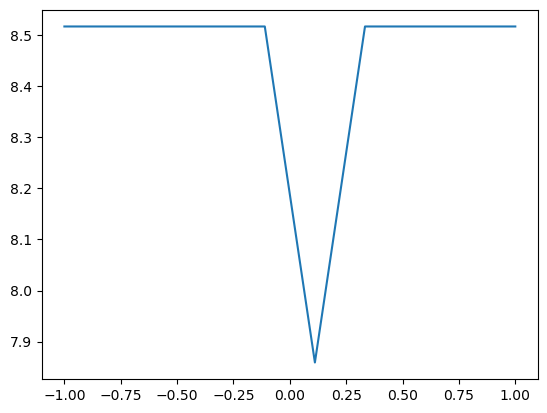

In [10]:
plt.plot(vect_lambd,np.log(niter))
print(niter)

In [11]:
k=np.argmin(niter)
print(k,'indice qui correspond au nombre d''itérations minimale de l''algo de descente de gradient')
print(niter[k],'correspond au nombre d''itérations minimale de l''algo de descente de gradient')
lambd_opt=vect_lambd[k]
print(lambd_opt,'la valeur optimale de lambda associé à niter minimale')

5 indice qui correspond au nombre ditérations minimale de lalgo de descente de gradient
2589.0 correspond au nombre ditérations minimale de lalgo de descente de gradient
0.11111111111111116 la valeur optimale de lambda associé à niter minimale


Par la suite , on prendra $\lambda$ égale à 0.11111111111111116 et $\mu$ = 0.1$\lambda$
Dans ce cas, on obtient ci-dessous, une fonction finale égale à la fonction target.

In [12]:
lamb=0.11111111111111116
mu=0.011111111111111116
nitermax=5000

step0 =0.1
ux,uy,CF,step,niter=RecalageDG(f,g,lamb,mu,nitermax,step0)

iteration : 3  cost function : 18.618896932611236 step : 0.8
iteration : 6  cost function : 14.988649458581124 step : 6.4
iteration : 9  cost function : 6.253350155244529 step : 3.2
iteration : 12  cost function : 5.66641590608094 step : 1.6
iteration : 15  cost function : 5.050452267479189 step : 1.6
iteration : 18  cost function : 4.675066440198215 step : 1.6
iteration : 21  cost function : 4.358644438079138 step : 1.6
iteration : 24  cost function : 4.091246554549395 step : 1.6
iteration : 27  cost function : 3.7588666350411453 step : 3.2
iteration : 30  cost function : 3.5086018793583884 step : 3.2
iteration : 33  cost function : 3.2857513951420403 step : 1.6
iteration : 36  cost function : 3.0896040684373647 step : 1.6
iteration : 39  cost function : 2.9214371596841993 step : 1.6
iteration : 42  cost function : 2.7168285722684975 step : 3.2
iteration : 45  cost function : 2.5562696565858003 step : 3.2
iteration : 48  cost function : 2.413063559119502 step : 1.6
iteration : 51  cos

iteration : 513  cost function : 0.43974480665552673 step : 3.2
iteration : 516  cost function : 0.4385912903429159 step : 1.6
iteration : 519  cost function : 0.4374805321688258 step : 1.6
iteration : 522  cost function : 0.43643897584801516 step : 1.6
iteration : 525  cost function : 0.4354910412907568 step : 1.6
iteration : 528  cost function : 0.43406246870755233 step : 3.2
iteration : 531  cost function : 0.43294988816949653 step : 1.6
iteration : 534  cost function : 0.431879735614754 step : 1.6
iteration : 537  cost function : 0.4308665425695593 step : 1.6
iteration : 540  cost function : 0.4299397495971468 step : 1.6
iteration : 543  cost function : 0.4286177966911777 step : 3.2
iteration : 546  cost function : 0.4275478261260525 step : 1.6
iteration : 549  cost function : 0.4265144403554225 step : 1.6
iteration : 552  cost function : 0.4255317947855429 step : 1.6
iteration : 555  cost function : 0.4246255707065298 step : 1.6
iteration : 558  cost function : 0.42340017673329483

iteration : 1038  cost function : 0.3297877364883217 step : 1.6
iteration : 1041  cost function : 0.3295544512946909 step : 1.6
iteration : 1044  cost function : 0.32919061219263696 step : 3.2
iteration : 1047  cost function : 0.32891230325334764 step : 1.6
iteration : 1050  cost function : 0.32864303833490605 step : 1.6
iteration : 1053  cost function : 0.32838991702375114 step : 1.6
iteration : 1056  cost function : 0.32815698770921675 step : 1.6
iteration : 1059  cost function : 0.32782112001014324 step : 3.2
iteration : 1062  cost function : 0.3275511836355464 step : 1.6
iteration : 1065  cost function : 0.32729145239137625 step : 1.6
iteration : 1068  cost function : 0.3270434526858488 step : 1.6
iteration : 1071  cost function : 0.3268166042075271 step : 1.6
iteration : 1074  cost function : 0.3265035691071676 step : 3.2
iteration : 1077  cost function : 0.32624401330840264 step : 1.6
iteration : 1080  cost function : 0.32599161817410605 step : 1.6
iteration : 1083  cost function

iteration : 1566  cost function : 0.3054730948799304 step : 1.6
iteration : 1569  cost function : 0.3054386432934413 step : 1.6
iteration : 1572  cost function : 0.3053864411183628 step : 3.2
iteration : 1575  cost function : 0.30534623004629113 step : 1.6
iteration : 1578  cost function : 0.3053070425584863 step : 1.6
iteration : 1581  cost function : 0.3052710021231265 step : 1.6
iteration : 1584  cost function : 0.3052371812317372 step : 1.6
iteration : 1587  cost function : 0.30519067638385416 step : 3.2
iteration : 1590  cost function : 0.3051525307117521 step : 1.6
iteration : 1593  cost function : 0.3051165254344866 step : 1.6
iteration : 1596  cost function : 0.30508175935561765 step : 1.6
iteration : 1599  cost function : 0.3050508931276215 step : 1.6
iteration : 1602  cost function : 0.30500777585776156 step : 3.2
iteration : 1605  cost function : 0.3049726470965985 step : 3.2
iteration : 1608  cost function : 0.30493826176122796 step : 1.6
iteration : 1611  cost function : 0

iteration : 2100  cost function : 0.29813078908113866 step : 1.6
iteration : 2103  cost function : 0.29809811431759103 step : 1.6
iteration : 2106  cost function : 0.29806586350372066 step : 1.6
iteration : 2109  cost function : 0.2980377677310841 step : 1.6
iteration : 2112  cost function : 0.2979961539075614 step : 3.2
iteration : 2115  cost function : 0.29796311432782135 step : 1.6
iteration : 2118  cost function : 0.29793016681061435 step : 1.6
iteration : 2121  cost function : 0.2978999005585972 step : 1.6
iteration : 2124  cost function : 0.2978703698616688 step : 1.6
iteration : 2127  cost function : 0.2978329247559804 step : 3.2
iteration : 2130  cost function : 0.29780002555368174 step : 3.2
iteration : 2133  cost function : 0.2977689196124993 step : 1.6
iteration : 2136  cost function : 0.2977380311793764 step : 1.6
iteration : 2139  cost function : 0.2977104731125021 step : 1.6
iteration : 2142  cost function : 0.29768412250781906 step : 1.6
iteration : 2145  cost function :

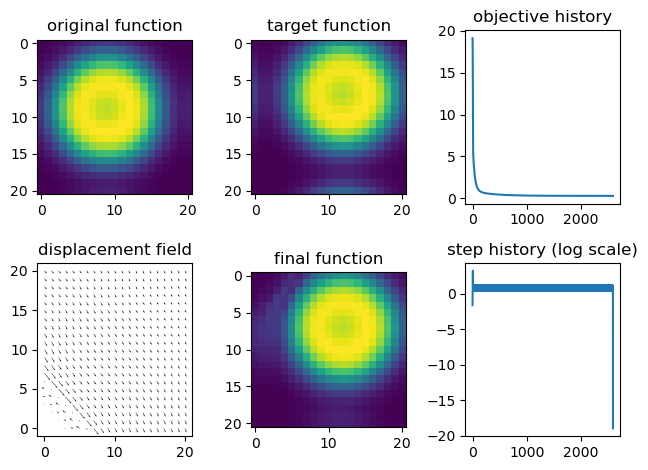

In [13]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

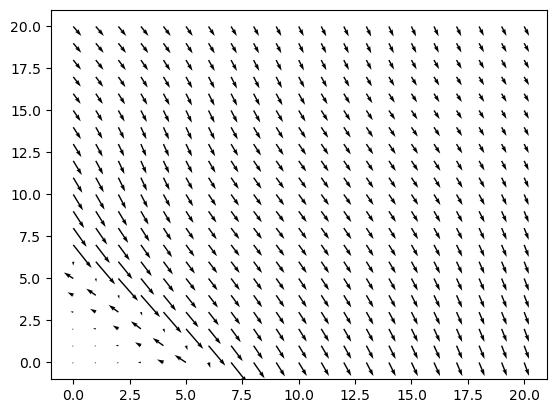

In [14]:
plt.quiver(ux, uy)
plt.show()

Le graphe ci-dessus contenant l'ensemble des vecteurs (ux,uy) résume le déplacement de notre fonction.
Cela correspond bien aux graphes de la fonction originale et la fonction objective.
En effet, on a bien qu'en bas à gauche, l'angle ne change pas d'une image à une autre (vecteur nul dans le graphe de quiver) cependant on note des vecteurs non nuls sur le reste du graphe de quiver, ceci explique bien le déplacement de l'objet entre les deux images.

# 4. Algorithme de moindres carrés.

On souhaite maintenant implémenter un algorithme de second ordre pour résoudre le problème $(P)\quad\min_u E(u)+R(u)$ afin d'accélérer la convergence de l'algorithme. Pour cela, on va reformuler le problème $(P)$ en un problème de moindres carrés et appliquer l'algorithme de Levenberg-Marquardt.

Soit:
$$\Psi(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix},$$
où $f\circ(id+u)$ est l'interpolation de $x\mapsto f(x+u(x))$ sur la grille. Minimiser $E(u)+R(u)$ est équivalent à résoudre le problème suivant:

>$$\min_u \|\Psi(u)\|_2^2.$$

Il s'agit maintenant d'un problème de moindres carrés que l'on va résoudre à l'aide de l'algorithme de Levenberg Marquardt :

$$
u_{k+1}=u_k- H_k^{-1} J_{\Psi}(u_k)^\top \Psi(u_k) \quad\mbox{ avec }\quad H_k=J_{\Psi}(u_k)^\top J_{\Psi}(u_k) +\varepsilon Id
$$

Q6. Calculer la matrice jacobienne de $\Psi$, notée $J_\Psi(u)$.

On sait que:
$$J_{\psi}(u)=\begin{pmatrix} 
\nabla _{\psi_1}(u)^T \\ 
\nabla _{\psi_2}(u)^T \\
\nabla _{\psi_3}(u)^T \
 \end{pmatrix}$$
 
 De plus, $${\psi}(u)=\begin{pmatrix} 
{\psi_1}(u) \\ 
{\psi_2}(u) \\
{\psi_3}(u) \\
 \end{pmatrix}$$ 
 et 
$${\psi}(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix}$$

Afin de déterminer $J_{\psi}(u)$ , on calcule les différentes valeurs $\nabla _{\psi_1}$ ,$\nabla _{\psi_2}$,$\nabla _{\psi_3}$ :

$$\begin{align}
\nabla _{\psi_2}(u)&=\sqrt{\mu} \nabla(\partial _x u_y + \partial _y u_x)\\
&=\sqrt{\mu}  \nabla \begin{pmatrix} 
\partial _y  \\
\partial _x  \\
\end{pmatrix}
\begin{pmatrix} 
u _x  \\
u _y  \\
\end{pmatrix}
\end{align}$$
Donc , par suite , on a bien que :
$$\begin{align}
\nabla _{\psi_2}&=\sqrt{\mu} \begin{pmatrix} 
\partial _y  \\
\partial _x  \\
\end{pmatrix}
\end{align}$$

Calculons ensuite $\nabla _{\psi_3}$ :
$$\begin{align}
\nabla _{\psi_3}(u)&=\sqrt{\mu+\lambda}  \nabla(\partial _x u_x + \partial _y u_y)\\
&=\sqrt{\mu+\lambda}\nabla \begin{pmatrix} 
\partial _x  \\
\partial _y  \\
\end{pmatrix}
\begin{pmatrix} 
u _x  \\
u _y  \\
\end{pmatrix}
\end{align}$$
Donc par suite , on a bien que :
$$\begin{align}
\nabla _{\psi_3}&=\sqrt{\mu+\lambda} \begin{pmatrix} 
\partial _x \\
\partial _y  \\
\end{pmatrix}
\end{align}$$
Enfin , on calculera $\nabla _{\psi_1}$ :
on sait que $(J_{\psi_1}(u))^T$=$\nabla _{\psi_1}(u)$ et $J_{Id+u}(u)=\nabla^T(Id+u)(u)=Id$

$$\begin{align}
J_{\psi_1}(u)&=J_f(Id+u) \times J_{Id+u}(u) \\
&=\nabla^Tf(Id+u) \times Id \\
&=\nabla^Tf(Id+u)  
\end{align}$$

On obtient donc:
$$\begin{align}
J_{\psi}(u) = \begin{pmatrix}
df_x(Id+u) & df_y(Id+u) \\
\sqrt{\mu}\partial _y & \sqrt{\mu}\partial _x  \\
\sqrt{\lambda + \mu}\partial _x & \sqrt{\lambda +\mu}\partial _y \\
\end{pmatrix}
\end{align}$$


Q7. Implémenter les fonctions JPsi, JTPsi et JTJ qui calculent respectivement:
- le produit de $J_\psi(u)$ par une direction $v=(v_x,v_y)\in V^2$,

- le produit de $J_\Psi(u)^\top$ par $\phi=(\phi_1,\phi_2,\phi_3)\in V^3$,

- le produit de $(J_\Psi(u)^\top J_\Psi(u)+\epsilon I)$ par une direction $v=(v_x,v_y)\in V^2$.

In [15]:
def JTPsi(phi,df,lamb,mu) :
    ux=phi[0]*df[0]+np.sqrt(mu)*dyT(phi[1])+np.sqrt(lamb+mu)*dxT(phi[2])
    uy=phi[0]*df[1]+np.sqrt(mu)*dxT(phi[1])+np.sqrt(lamb+mu)*dyT(phi[2])
    return [ux,uy]


def JPsi(vx,vy,df,lamb,mu) :
    JPsi0=df[0]*vx+df[1]*vy
    JPsi1=np.sqrt(mu)*dy(vx)+np.sqrt(mu)*dx(vy)
    JPsi2=np.sqrt(mu+lamb)*dx(vx)+np.sqrt(mu+lamb)*dy(vy)
    return [JPsi0,JPsi1,JPsi2]
  
def JTJ(vx,vy,df,lamb,mu,epsilon) :
    uxs,uys=JTPsi(JPsi(vx,vy,df,lamb,mu),df,lamb,mu)
    uxs=uxs+epsilon*vx
    uys=uys+epsilon*vy 
    return uxs,uys

Calculons maintenant la direction de recherche $d_k$ comme solution du système linéaire:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = -J_\Psi(u_k)^\top \Psi(u_k)$$
Pour cela, on vous donne l'algorithme suivant qui par la méthode du gradient conjugué calcule une solution $d=(d_x,d_y)\in V^2$ du problème:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = b$$

In [16]:
 def CGSolve(u0x,u0y,lamb,mu,b,epsilon,df) :
    nitmax=100;
    ux=u0x; uy=u0y; #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,df,lamb,mu,epsilon);
    rx=b[0]-Ax
    ry=b[1]-Ay
    px=rx
    py=ry
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,df,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return [ux,uy]

Q8. Compléter l'algorithme RecalageGN implémentant la méthode de Levenberg-Marquardt.

In [17]:
def psi(fu,g,lamb,mu,ux,uy):
    psi1=fu-g
    psi2=np.sqrt(mu)*dy(ux)+np.sqrt(mu)*dx(uy)
    psi3=np.sqrt(lamb+mu)*dx(ux)+np.sqrt(lamb+mu)*dy(uy)
    return [psi1,psi2,psi3]
def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)  
    #raise ValueError('To complete if necessary')
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dfx=dx(f)
    dfy=dy(f)
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        #raise ValueError('Compute b here')
        #raise ValueError('Compute dfx,dfy here')
        dfx1=interpol(dfx,ux,uy)
        dfy1=interpol(dfy,ux,uy)
        df=[dfx1,dfy1]
        psi1=psi(fu,g,lamb,mu,ux,uy)
        b=JTPsi(psi1,df,lamb,mu)
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,df)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

Q9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

Afin que l'algorithme des moindres carrés converge avec un nombre d'itéarations le plus minimal possible,j'ai décidé de créér une fonction qui permet de calculer les valeurs de $\lambda$ et $\mu$ les plus optimales possibles.
Pour cela , pour différentes valeurs de $\lambda$ ,j'ai calculé le nombre d'itérations associé en Log. 

In [18]:
nitermax=5000
epsi=0.1
step0=0.01
v_lamb=np.linspace(0,60,30)
v_mu=np.copy(v_lamb)
niter=np.zeros(30)
for i in range (30):
    ux,uy,CF,step,niter[i]=RecalageGN(f,g,v_lamb[i],v_mu[i],nitermax,step0,epsi)

iteration : 3  cost function : 18.73324891787389 step : 0.08
iteration : 6  cost function : 15.390488694830228 step : 0.64
iteration : 9  cost function : 3.581852271528054 step : 5.12
iteration : 12  cost function : 1.6262697498641454 step : 5.12
iteration : 15  cost function : 1.291069312350728 step : 10.24
iteration : 18  cost function : 1.2220570540253008 step : 5.12
iteration : 21  cost function : 1.156019983316257 step : 10.24
iteration : 24  cost function : 1.129399108665922 step : 10.24
iteration : 27  cost function : 1.110816675420118 step : 10.24
iteration : 30  cost function : 1.0962568942912683 step : 10.24
iteration : 33  cost function : 1.086495035159741 step : 5.12
iteration : 36  cost function : 1.0730801953354112 step : 5.12
iteration : 39  cost function : 1.0635328650999776 step : 5.12
iteration : 42  cost function : 1.0552463888102417 step : 10.24
iteration : 45  cost function : 1.050322878697209 step : 10.24
iteration : 48  cost function : 1.046099117142508 step : 10

iteration : 453  cost function : 1.005124101747051 step : 10.24
iteration : 456  cost function : 1.0051118126600576 step : 10.24
iteration : 459  cost function : 1.0051007407927908 step : 10.24
iteration : 462  cost function : 1.0050907535697655 step : 10.24
iteration : 465  cost function : 1.0050817307318591 step : 10.24
iteration : 468  cost function : 1.0050735637970416 step : 10.24
iteration : 471  cost function : 1.0050661553952507 step : 10.24
iteration : 474  cost function : 1.0050594184554382 step : 10.24
iteration : 477  cost function : 1.0050532753864294 step : 10.24
iteration : 480  cost function : 1.0050476572327882 step : 10.24
iteration : 483  cost function : 1.0050425028378835 step : 10.24
iteration : 486  cost function : 1.0050377580254128 step : 10.24
iteration : 489  cost function : 1.0050333748786602 step : 10.24
iteration : 492  cost function : 1.00502931106898 step : 10.24
iteration : 495  cost function : 1.0050255293578174 step : 10.24
iteration : 498  cost functi

iteration : 30  cost function : 0.2972330913095006 step : 2.56
iteration : 33  cost function : 0.28265881187158054 step : 1.28
iteration : 36  cost function : 0.2686942409173834 step : 2.56
iteration : 39  cost function : 0.2604701240679174 step : 2.56
iteration : 42  cost function : 0.2559353418196065 step : 2.56
iteration : 45  cost function : 0.25312905183617124 step : 2.56
iteration : 48  cost function : 0.251706273279193 step : 2.56
iteration : 51  cost function : 0.25128291166351485 step : 1.28
iteration : 54  cost function : 0.25059993348218407 step : 2.56
iteration : 57  cost function : 0.2505535155953554 step : 9.5367431640625e-09
iteration : 3  cost function : 18.97372531010508 step : 0.08
iteration : 6  cost function : 17.722239279223594 step : 0.64
iteration : 9  cost function : 10.370808091933123 step : 5.12
iteration : 12  cost function : 1.2574823290829995 step : 2.56
iteration : 15  cost function : 0.9177835579779743 step : 1.28
iteration : 18  cost function : 0.5856213

iteration : 18  cost function : 0.5059975872974644 step : 1.28
iteration : 21  cost function : 0.3688527077638394 step : 1.28
iteration : 24  cost function : 0.30674942603454297 step : 1.28
iteration : 27  cost function : 0.27681100166346945 step : 2.56
iteration : 30  cost function : 0.26284993697494935 step : 2.56
iteration : 33  cost function : 0.2559080109303823 step : 2.56
iteration : 36  cost function : 0.2526593566464099 step : 2.56
iteration : 39  cost function : 0.25101111358215816 step : 2.56
iteration : 42  cost function : 0.25027496957649253 step : 2.56
iteration : 45  cost function : 0.24992388333728394 step : 2.56
iteration : 48  cost function : 0.24979484547940414 step : 2.56
iteration : 3  cost function : 18.988972595225903 step : 0.08
iteration : 6  cost function : 17.844772657641997 step : 0.64
iteration : 9  cost function : 10.591607606158385 step : 5.12
iteration : 12  cost function : 1.617286410671298 step : 1.28
iteration : 15  cost function : 0.8077649890761941 s

iteration : 36  cost function : 0.2525551908095287 step : 1.28
iteration : 39  cost function : 0.2511290624205495 step : 1.28
iteration : 42  cost function : 0.2504506516830824 step : 2.56
iteration : 45  cost function : 0.25011143281132286 step : 1.28
iteration : 48  cost function : 0.24995834328864847 step : 2.56
iteration : 51  cost function : 0.2498984555213306 step : 0.64
iteration : 54  cost function : 0.249896252221598 step : 9.5367431640625e-09
iteration : 3  cost function : 18.992950766069814 step : 0.08
iteration : 6  cost function : 17.872700446218957 step : 0.64
iteration : 9  cost function : 10.62562675788621 step : 5.12
iteration : 12  cost function : 1.2210283130638357 step : 2.56
iteration : 15  cost function : 0.6919988081489425 step : 2.56
iteration : 18  cost function : 0.5245676398111525 step : 1.28
iteration : 21  cost function : 0.368488114711255 step : 1.28
iteration : 24  cost function : 0.303664662625845 step : 1.28
iteration : 27  cost function : 0.27474148917

iteration : 33  cost function : 0.25426491272274354 step : 2.56
iteration : 36  cost function : 0.2522208092047877 step : 2.56
iteration : 39  cost function : 0.25151728203217677 step : 1.28
iteration : 42  cost function : 0.25074350685477 step : 1.28
iteration : 45  cost function : 0.2503369475318972 step : 1.28
iteration : 48  cost function : 0.2501458558305063 step : 1.28
iteration : 51  cost function : 0.25005859117304574 step : 1.28
iteration : 3  cost function : 18.99559482680646 step : 0.08
iteration : 6  cost function : 17.888793559748446 step : 0.64
iteration : 9  cost function : 10.641284161568066 step : 5.12
iteration : 12  cost function : 1.2155315684568562 step : 2.56
iteration : 15  cost function : 0.6528771541463008 step : 2.56
iteration : 18  cost function : 0.41735530257846976 step : 2.56
iteration : 21  cost function : 0.3224642905560656 step : 2.56
iteration : 24  cost function : 0.28271719873076223 step : 2.56
iteration : 27  cost function : 0.26548904266094625 step

On trace ci-dessous la fonction log(niter) en fonction de lambda.

[743.  68.  57.  52.  50.  49.  49.  51.  50.  51.  50.  52.  52.  53.
  63.  52.  62.  54.  51.  52.  52.  52.  52.  52.  52.  52.  52.  52.
  55.  54.]


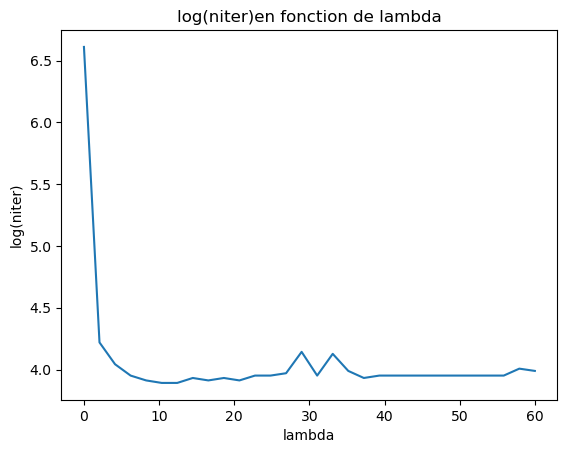

In [19]:

plt.show()
plt.title('log(niter)en fonction de lambda')
plt.xlabel('lambda')
plt.ylabel('log(niter)')
plt.plot(v_lamb,np.log(niter))
print(niter)

In [20]:
k=np.argmin(niter)
print(k, 'est l''indice qui correspond à la valeur de niter minimale')
print(niter[k],'représente la valeur de niter minimale')
lambda_opt=v_lamb[k]
print(lambda_opt,'représente la valeur de lambda optimale')

5 est lindice qui correspond à la valeur de niter minimale
49.0 représente la valeur de niter minimale
10.344827586206897 représente la valeur de lambda optimale


On remarque que l'algorithme converge lorsque le nombre d'itérations est égale à 49. La valeur de $\lambda$ associé est égale à 10.344827586206897 , c'est bel et bien la valeur optimale de $\lambda$. 

In [21]:
epsi=0.1
nitermax=100
lamb=10.344827586206897
mu=10.344827586206897
ux,uy,CF,step,niter=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 18.980738143768278 step : 0.08
iteration : 6  cost function : 17.77995806584432 step : 0.64
iteration : 9  cost function : 10.48750056552422 step : 5.12
iteration : 12  cost function : 1.2581385111202377 step : 2.56
iteration : 15  cost function : 0.8733688909132206 step : 1.28
iteration : 18  cost function : 0.5515327259787275 step : 1.28
iteration : 21  cost function : 0.3995331304334949 step : 2.56
iteration : 24  cost function : 0.32636696278754185 step : 2.56
iteration : 27  cost function : 0.28871259437604946 step : 2.56
iteration : 30  cost function : 0.26969172596087443 step : 2.56
iteration : 33  cost function : 0.25955411629296304 step : 2.56
iteration : 36  cost function : 0.2544248218702207 step : 2.56
iteration : 39  cost function : 0.25171996219395804 step : 2.56
iteration : 42  cost function : 0.25044111273447456 step : 2.56
iteration : 45  cost function : 0.2500618820130859 step : 1.28
iteration : 48  cost function : 0.2496309942056984 ste

On remarque que l'algorithme des moindres carrés converge plus rapidement comparant à l'algorithme de descente de gradient.
En effet ,le nombre d'itérations de l'algorithme des moindres carrés est égale à 48 qui est très inférieure au nombre d'itérations de l'algorithme de descente de gradient qui est égale à 2589.

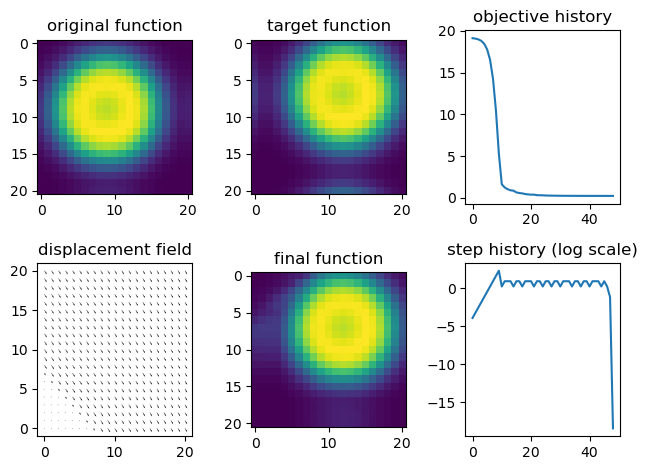

In [22]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

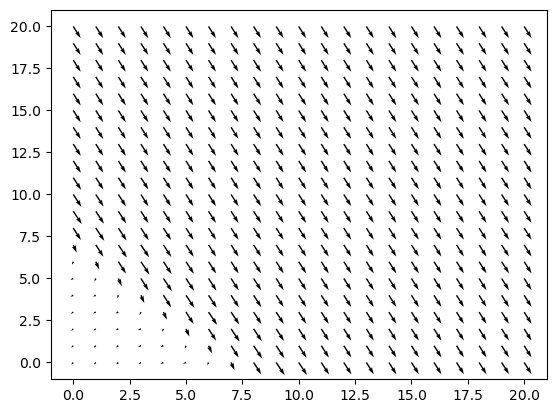

In [23]:
plt.quiver(ux, uy)
plt.show()

Le graphe ci-dessus contenant l'ensemble des vecteurs (ux,uy) résume le déplacement de notre fonction. Cela correspond bien aux graphes de la fonction originale et la fonction objective. En effet, on a bien qu'en bas à gauche, l'angle ne change pas d'une image à une autre (vecteur nul dans le graphe de quiver) cependant on note des vecteurs non nuls sur le reste du graphe de quiver, ceci explique bien le déplacement de l'objet entre les deux images.



5. Jeu des différences
======================
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

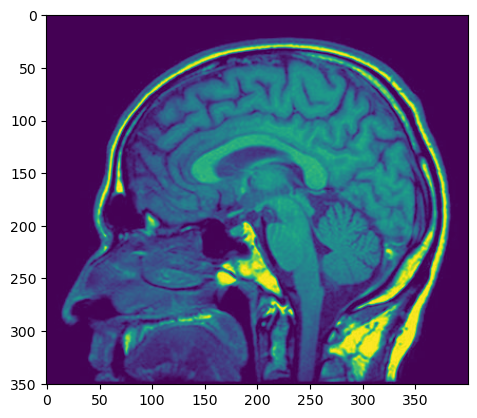

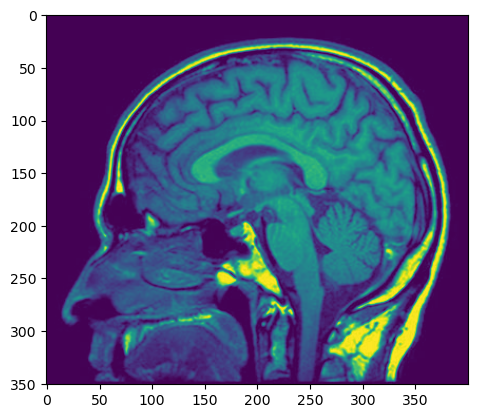

In [24]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

In [25]:
[n,m]=im1.size
sigma=0.2
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

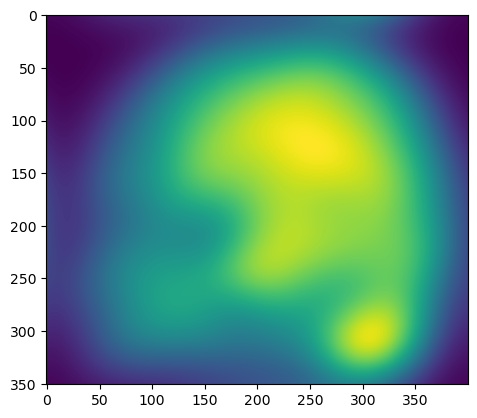

In [26]:
plt.imshow(f)

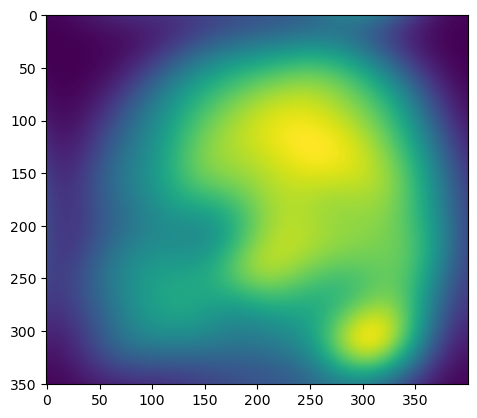

In [27]:
plt.imshow(g)

In [28]:
[n,m]=im1.size
sigma=0.01
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

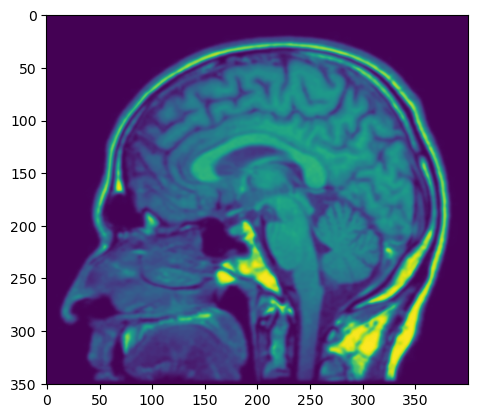

In [29]:
plt.imshow(f)

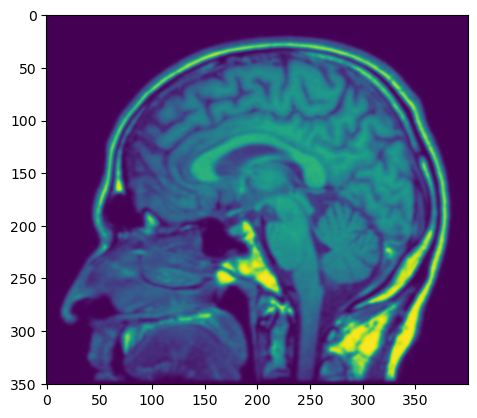

In [30]:
plt.imshow(g)

Tout d'abord, on choisit l'algorithme des moindres carrés afin de minimiser le nombre d'itérations.
Dans le cas de l'algorithme de descente de gradient, cela peut prendre un temps exorbitant afin d'assurer la convergence.

In [31]:
epsi=0.01
step0=0.01
nitermax=500
lamb=0.0001
mu=0.0001
ux,uy,CF,step,niter=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 2.6839462465073978 step : 0.08
iteration : 6  cost function : 2.0284033105056767 step : 0.64
iteration : 9  cost function : 0.4869730160177394 step : 5.12
iteration : 12  cost function : 0.14085249407064304 step : 2.56
iteration : 15  cost function : 0.11114494221439977 step : 2.56
iteration : 18  cost function : 0.09599077292026556 step : 2.56
iteration : 21  cost function : 0.08524067632652496 step : 1.28
iteration : 24  cost function : 0.07494773124600218 step : 2.56
iteration : 27  cost function : 0.06839865099956086 step : 5.12
iteration : 30  cost function : 0.06304705330287422 step : 2.56
iteration : 33  cost function : 0.05992059326327939 step : 2.56
iteration : 36  cost function : 0.05680617009055569 step : 2.56
iteration : 39  cost function : 0.05453130160712284 step : 2.56
iteration : 42  cost function : 0.05219698175710828 step : 2.56
iteration : 45  cost function : 0.0504764877290117 step : 2.56
iteration : 48  cost function : 0.0486220421717

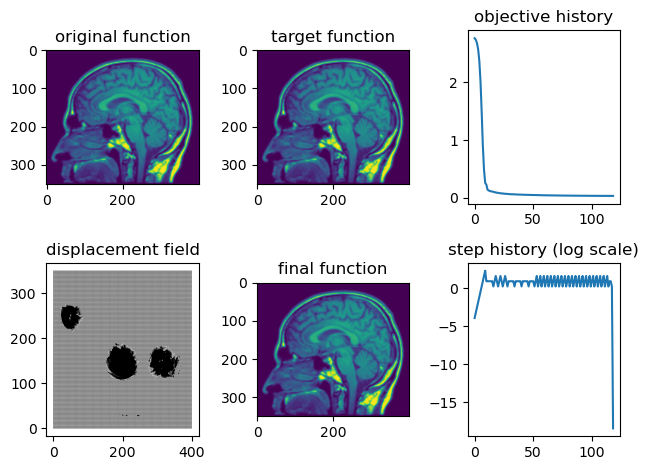

In [32]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

En choisissant des valeurs de lambda et de mu élevées (par exemple: $\lambda$=$\mu$=8), on remarque que même
avec l'algorithme des moindres carrés ( qui converge plus rapidement que celui de descente de gradient) , cela prend aussi un temps énorme ainsi qu'un nombre d'itérations assez conséquent avant d'assurer la convergence. C'est pour cela que j'ai décidé de choisir des valeurs $\lambda$=$\mu$=0.0001.
La valeur de $\sigma$ agit aussi sur la pertinence des résultats obtenus. En effet , pour $\sigma$=0.2, les deux images f et g sont presque identiques et on observe une tâche colorée et floue au niveau du crâne.Cela ne nous aide pas à determiner avec precision les endroits là où a lieu les changements.
Cependant, en réduisant la valeur de $\sigma$ à 0.01, on pourra distinguer les différences entre les deux images.
Cela est bel et bien représenté dans la figure 'displacement filed'. En effet les tâches en noir représentent les endroits où on a eu du changement (différences entre la fonction initiale et finale).
De plus , en réduisant avec précaution la valeur de $\epsilon$, le nombre d'itérations diminue par conséquent (il faut toujours avoir un nombre d'itération suffisant pour assurer la convergence).